# Shortcut

to download interactions without running notebook go to:

https://drive.google.com/drive/folders/1QDJysd4CeW2U-IzwqOOgotS-msYwk8_z?usp=share_link

# Calculate communication

In [1]:
# libraries
library(community)
library(dplyr)
require(ggplot2)
require(gridExtra)
require(grid)
require(ComplexHeatmap)
require(dendsort)
require(igraph)
require(circlize)
require(R.utils)
require(data.table) #to read gz file
require(org.Hs.eg.db)
require(clusterProfiler)


Attache Paket: ‘dplyr’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    filter, lag


Die folgenden Objekte sind maskiert von ‘package:base’:

    intersect, setdiff, setequal, union


Lade nötiges Paket: ggplot2

Lade nötiges Paket: gridExtra


Attache Paket: ‘gridExtra’


Das folgende Objekt ist maskiert ‘package:dplyr’:

    combine


Lade nötiges Paket: grid

Lade nötiges Paket: ComplexHeatmap

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero 

In [2]:
# the path to the counts, cell annotation and sample annation file. In this case its our working dir same as
# the notebook
path_in <- paste0(getwd(),"/rdata")

print("path_in")
print(path_in)

[1] "path_in"
[1] "/work/project/ladcol_013/algo_ulc/rdata"


In [3]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/fsalcher/miniconda3/envs/community_tutorial/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=de_AT.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_AT.UTF-8        LC_COLLATE=de_AT.UTF-8    
 [5] LC_MONETARY=de_AT.UTF-8    LC_MESSAGES=de_AT.UTF-8   
 [7] LC_PAPER=de_AT.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_AT.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] clusterProfiler_4.6.2 org.Hs.eg.db_3.16.0   AnnotationDbi_1.60.2 
 [4] IRanges_2.32.0        S4Vectors_0.36.2      Biobase_2.58.0       
 [7] BiocGenerics_0.44.0   data.table_1.14.8     R.utils_2.12.2       
[10] R.oo_1.25.0           R.methodsS3_1.8.2     c

## Load data

**Note:** Running this notebook takes around 15 minutes depending on your hardware configration. If you'd like to skip computing the results, please load `interactions.RData` file.

To calculate interactions, we will need the following files: normalized and batch corrected `counts`, cell annotation file `anno_cells`, and a sample annotation file `anno_samples`.

The `counts` file contains normalized and batch corrected counts with genes in the rows and cell IDs in the columns.

The `anno_cells` file should contain columns named cell_ID, cell_type and sample_ID.

The `anno_sample` file should countan columns named sample_ID health_status (e.g. "healthy" or "AML") and case_or_conrol (e.g. "control" or "case").

In [4]:
load(file = paste0(path_in,"/LR_database.rda"))
print(str(LR_database))

'data.frame':	6858 obs. of  26 variables:
 $ Pair.Name            : chr  "ADAM12_ITGB1" "ADAM12_SDC4" "ADAM15_ITGA5" "ADAM15_ITGA9" ...
 $ Ligand               : chr  "ADAM12" "ADAM12" "ADAM15" "ADAM15" ...
 $ Ligand.Name          : chr  "ADAM metallopeptidase domain 12" "ADAM metallopeptidase domain 12" "ADAM metallopeptidase domain 15" "ADAM metallopeptidase domain 15" ...
 $ Receptor             : chr  "ITGB1" "SDC4" "ITGA5" "ITGA9" ...
 $ Receptor.Name        : chr  "integrin subunit beta 1" "syndecan 4" "integrin subunit alpha 5" "integrin subunit alpha 9" ...
 $ complex_pair         : chr  NA NA NA NA ...
 $ partner_a            : chr  "O43184" "O43184" "Q13444" "Q13444" ...
 $ partner_b            : chr  "P05556" "P31431" "P08648" "Q13797" ...
 $ source               : chr  "O43184" "O43184" "Q13444" "Q13444" ...
 $ target               : chr  "P05556" "P31431" "P08648" "Q13797" ...
 $ source_genesymbol    : chr  "ADAM12" "ADAM12" "ADAM15" "ADAM15" ...
 $ target_genesymbol    : 

In [5]:
# # load counts
print("load counts")
counts <- fread("./pdata/counts_corr.csv.gz", header = TRUE)
counts <- as.data.frame(counts)
rownames(counts) <- counts$gene_symbol
counts <- counts[,-1]
print(str(counts))

[1] "load counts"
'data.frame':	13146 obs. of  132126 variables:
 $ N10.LPA.TTGCTATGACGCAT    : num  0 0 0 0 0 ...
 $ N13.LPA.AACCTTACTGCTTT    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N13.LPA.ACAATCCTCTGAAC    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N13.LPA.AGTGACTGGATACC    : num  0 0 0 0 0 ...
 $ N13.LPA.ATAGATACTGAGCT    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N13.LPA.CCCAACACGGTATC    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N13.LPA.CGGAGGCTTCCTTA    : num  0 0 0 0 0 ...
 $ N13.LPA.TAAACAACTTACTC    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N13.LPA.TACTGTTGCGTAAC    : num  0 0 0 0 0 ...
 $ N13.LPA.TCGATACTATGGTC    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N15.LPA.ATGCGCCTCAACTG    : num  0 0.998 0 0 0 ...
 $ N15.LPA.GCACAAACAACGAA    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N15.LPA.GCTACCTGCCTAAG    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N15.LPA.GTATTCACCATGGT    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N15.LPA.TTGAACCTGTGAGG    : num  0 0 0 0 0 ...
 $ N16.LPA.AGTTTGCTCCCTAC    : num  0 0 0 0 0.641 ...
 $ N16.LPA.CACAACGACGTTGA    : num  0

In [6]:
# load cell annotation
print("load cell annotation")
anno_cells <- read.table("./pdata/anno_cells_corr.txt"
                         ,sep = "\t"
                         #,row.names = 2
                         ,header = TRUE
                         )
anno_cells$placeholder <- anno_cells$cell_ID
row.names(anno_cells) <- anno_cells$placeholder
anno_cells <- anno_cells[,-1]
print(str(anno_cells))

[1] "load cell annotation"
'data.frame':	132126 obs. of  25 variables:
 $ cell_ID                      : chr  "N10.LPA.TTGCTATGACGCAT" "N13.LPA.AACCTTACTGCTTT" "N13.LPA.ACAATCCTCTGAAC" "N13.LPA.AGTGACTGGATACC" ...
 $ cell_type_original           : chr  "Stem" "Stem" "Stem" "Stem" ...
 $ tissue_type                  : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ cell_type                    : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ region                       : chr  "Healthy" "Healthy" "Healthy" "Healthy" ...
 $ sample_ID                    : chr  "N10.LPA_Healthy" "N13.LPA_Healthy" "N13.LPA_Healthy" "N13.LPA_Healthy" ...
 $ health_status                : chr  "Healthy" "Healthy" "Healthy" "Healthy" ...
 $ total_counts_raw             : int  8269 5413 6372 6946 3485 4225 1506 7552 10331 5610 ...
 $ nr_genes                     : int  1554 1219 1336 1303 945 1031 470 1502 1779 1188 ...
 $ counts_upper_threshold       : int  30000 30000 30000 30

In [7]:
# load sample annotation
print("load sample annotation")
anno_samples <- read.table("./pdata/anno_samples_corr.txt"
                           ,sep = "\t"
                          #,row.names = 2
                           ,header = TRUE
                           )
anno_samples$placeholder <- anno_samples$sample_ID
row.names(anno_samples) <- anno_samples$placeholder

anno_samples <- anno_samples[,-1]
anno_samples = anno_samples[anno_samples$sample_ID %in% anno_cells$sample_ID,]
print(str(anno_samples))

[1] "load sample annotation"
'data.frame':	47 obs. of  13 variables:
 $ sample_ID                    : chr  "N10.LPA_Healthy" "N13.LPA_Healthy" "N15.LPA_Healthy" "N16.LPA_Healthy" ...
 $ patient_ID                   : chr  "N10" "N13" "N15" "N16" ...
 $ region                       : chr  "Healthy" "Healthy" "Healthy" "Healthy" ...
 $ case_or_control              : chr  "control" "control" "control" "control" ...
 $ health_status                : chr  "Healthy" "Healthy" "Healthy" "Healthy" ...
 $ nr_cells_raw                 : int  4635 1782 1896 1542 2288 2230 3710 1661 4708 817 ...
 $ nr_cells_cf                  : int  2824 1046 1074 806 1131 1425 2188 1094 3744 513 ...
 $ nr_cells_cf_ctf              : int  2802 1044 1065 797 1124 1415 2176 1092 3719 494 ...
 $ total_counts_raw_cf_ctf_gf   : int  8163510 3383881 3278561 2555642 4336475 4947371 5510584 4156465 15159797 1742023 ...
 $ nr_celltypes_cf_ctf_gf       : int  8 7 8 8 8 8 8 8 8 7 ...
 $ threshold_nr_celltypes       : chr  

In [8]:
#removal of outliers(see heatmap of 2.filtering)
#anno_samples <- anno_samples[!anno_samples$patient_ID == "N111",]
#anno_samples <- anno_samples[!anno_samples$patient_ID == "N51",]

In [9]:
# subsampling to only compare 5 Inflamed samples (that will also be used in notebook 5.2) and 5 Healthy samples
anno_samples <- anno_samples %>%
    filter(region %in% c("Healthy", "Inflamed")) %>%
    group_by(region) %>%
    arrange(patient_ID) %>%
    slice_head(n = 8) %>%
    ungroup()
rownames(anno_samples) <- anno_samples$sample_ID
anno_cells <- anno_cells[anno_cells$sample_ID %in% rownames(anno_samples),]
counts <- counts[,colnames(counts) %in% rownames(anno_cells)]

Warning message:
“Setting row names on a tibble is deprecated.”


In [10]:
anno_samples

sample_ID          patient_ID region   case_or_control health_status
1  N10.LPA_Healthy    N10        Healthy  control         Healthy      
2  N11.LPB_Healthy    N11        Healthy  control         Healthy      
3  N13.LPA_Healthy    N13        Healthy  control         Healthy      
4  N15.LPA_Healthy    N15        Healthy  control         Healthy      
5  N16.LPA_Healthy    N16        Healthy  control         Healthy      
6  N17.LPA_Healthy    N17        Healthy  control         Healthy      
7  N18.LPA_Healthy    N18        Healthy  control         Healthy      
8  N20.LPB_Healthy    N20        Healthy  control         Healthy      
9  N106.LPB_Inflamed  N106       Inflamed case            Colitis      
10 N110.LPB_Inflamed  N110       Inflamed case            Colitis      
11 N111.LPB1_Inflamed N111       Inflamed case            Colitis      
12 N12.LPB_Inflamed   N12        Inflamed case            Colitis      
13 N14.LPB_Inflamed   N14        Inflamed case            Colitis      
14 N19.LPB_Inflamed   N19        Inflamed case            Colitis      
15 N23.LPB_Inflamed   N23        Inflamed case            Colitis      
16 N24.LPB_Inflamed   N24        Inflamed case            Colitis      
   nr_cells_raw nr_cells_cf nr_cells_cf_ctf total_counts_raw_cf_ctf_gf
1   4635        2824        2802             8163510                  
2   1100         570         558             1411121                  
3   1782        1046        1044             3383881                  
4   1896        1074        1065             3278561                  
5   1542         806         797             2555642                  
6   2288        1131        1124             4336475                  
7   2230        1425        1415             4947371                  
8   3710        2188        2176             5510584                  
9   4272        3628        3628            15111208                  
10  3834        2913        2896            17762708                  
11 13175        9264        9254            26683847                  
12  1164         952         913             5008620                  
13  1462         855         855             2974626                  
14  1724        1382        1378            10137272                  
15  3537        2644        2640            13407738                  
16  2697        2076        2075            11549548                  
   nr_celltypes_cf_ctf_gf threshold_nr_celltypes passed_threshold_nr_celltypes
1  8                      greater or equal 7     True                         
2  7                      greater or equal 7     True                         
3  7                      greater or equal 7     True                         
4  8                      greater or equal 7     True                         
5  8                      greater or equal 7     True                         
6  8                      greater or equal 7     True                         
7  8                      greater or equal 7     True                         
8  8                      greater or equal 7     True                         
9  8                      greater or equal 7     True                         
10 8                      greater or equal 7     True                         
11 8                      greater or equal 7     True                         
12 8                      greater or equal 7     True                         
13 8                      greater or equal 7     True                         
14 7                      greater or equal 7     True                         
15 7                      greater or equal 7     True                         
16 8                      greater or equal 7     True                         
   placeholder       
1  N10.LPA_Healthy   
2  N11.LPB_Healthy   
3  N13.LPA_Healthy   
4  N15.LPA_Healthy   
5  N16.LPA_Healthy   
6  N17.LPA_Healthy   
7  N18.LPA_Healthy   
8  N20.LPB_Healthy   
9  N106.LPB_Inflamed 
10 N110.L

The ligand-receptor pair database is provided by the algorithm, but the user can also use a custom database. In this case, the custom database should have the columns named 'Ligand', 'Receptor' and 'Pair.Name'. 

## Thresholds

When calculation the interactions, it is possible to set three threshold: 
- `threshold_celltype_size` is a threshold for the minimum number of cells that a cell type should contain (in one sample). If the number of cells in the cell type of interest in a particular sample is less or equal to the `threshold_celltype_size`, then we consider this cell type as missing in this sample. This threshold affects the relative cell type abundance parameter (rho). The deafult value for the `threshold_celltype_size` is 4. 
- `threshold_nr_active_cells` is a threshold for the minimum number of active cells in a cell type (in the sample of interest). A cell is concidered as active (for a specific gene), if it is expressing this gene above the `threshold_expr`. If the number of active cells (for a specific gene) in a cell type is smaller or equal to the `threshold_nr_active_cells`, i.e. does not pass the threshold, then it is set to zero (in this sample). This threshold affects the relative active fraction (phi) parameter. The deafult value for the `threshold_expr` is zero.
- `threshold_expr` is a threshold for an expression value of a gene in a cell. If an expression value af a gene in a cell is smaller or equal to the `threshold_expr` value, it will be set to zero. This threshold affects the relative active fration (phi) and the relative mean expression (p) paramteres. The deafult value for the `threshold_expr` is zero. In our analysis, we will though set it arbtrarily to 0.05.

In [11]:
# set threshold of the cell type size
threshold_celltype_size <- 6
print("threshold_celltype_size >")
print(threshold_celltype_size)

[1] "threshold_celltype_size >"
[1] 6


In [12]:
# set threshold of the minimum number of active cells
threshold_nr_active_cells <- 6
print("threshold_nr_active_cells >")
print(threshold_nr_active_cells)

[1] "threshold_nr_active_cells >"
[1] 6


In [13]:
# set threshold of expression
threshold_expr <- 0.1
print("threshold_expr >")
print(threshold_expr)

[1] "threshold_expr >"
[1] 0.1


## Calculate interactions

In [14]:
# Renaming the cell_ID.1 column in anno_cells to "cell_ID"
colnames(anno_cells)[colnames(anno_cells) == "cell_ID.1"] <- "cell_ID"

In [15]:
print("calculate communication")
interactions = calculate_communication(counts = counts
                                       ,anno_samples = anno_samples
                                       ,anno_cells = anno_cells
                                       ,threshold_celltype_size = threshold_celltype_size
                                       ,threshold_nr_active_cells = threshold_nr_active_cells
                                       ,threshold_expr = threshold_expr
                                       ,lrp_database = LR_database
                                       )

# print(str(interactions))


[1] "calculate communication"


Warning message in e_cellType_gene(counts = counts_sub, anno_cells = anno_cells_sub, :
“WARNING: sample N11.LPB_Healthy does not contain cell type Epithelial -- interactions for this cell type in this sample will get zero values.”
Warning message in e_cellType_gene(counts = counts_sub, anno_cells = anno_cells_sub, :
“WARNING: sample N13.LPA_Healthy does not contain cell type Mast -- interactions for this cell type in this sample will get zero values.”
Warning message in e_cellType_gene(counts = counts_sub, anno_cells = anno_cells_sub, :
“WARNING: sample N19.LPB_Inflamed does not contain cell type B-cells -- interactions for this cell type in this sample will get zero values.”
Warning message in e_cellType_gene(counts = counts_sub, anno_cells = anno_cells_sub, :
“WARNING: sample N23.LPB_Inflamed does not contain cell type Fibroblasts -- interactions for this cell type in this sample will get zero values.”


In [16]:
print(str(interactions))

List of 23
 $ per_sample_anno_interactions:List of 16
  ..$ N10.LPA_Healthy   :'data.frame':	170688 obs. of  29 variables:
  .. ..$ interaction_ID     : chr [1:170688] "Epithelial:ADAM12_Epithelial:ITGB1" "Epithelial:ADAM12_Epithelial:SDC4" "Epithelial:ADAM15_Epithelial:ITGA5" "Epithelial:ADAM15_Epithelial:ITGA9" ...
  .. ..$ ligand_gene_name   : chr [1:170688] "ADAM12" "ADAM12" "ADAM15" "ADAM15" ...
  .. ..$ receptor_gene_name : chr [1:170688] "ITGB1" "SDC4" "ITGA5" "ITGA9" ...
  .. ..$ sending_cell_type  : chr [1:170688] "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
  .. ..$ receiving_cell_type: chr [1:170688] "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
  .. ..$ f_s                : num [1:170688] 0.0211 0.0211 0.0211 0.0211 0.0211 ...
  .. ..$ f_r                : num [1:170688] 0.0211 0.0211 0.0211 0.0211 0.0211 ...
  .. ..$ f_s_max            : num [1:170688] 0.643 0.643 0.643 0.643 0.643 ...
  .. ..$ f_r_max            : num [1:170688] 0.643 0.643 0.643 0.64

## Calculate general statistics

The `general_stat` function calculates for each interaction several parameters that will be used for the QC, visualization and the differential communication analysis. 

Following parameters for the QC step will be stored in the `anno_interactions` list:
- mean expression of a ligand in the active fraction of the sending cell type within the control cohort (`mean_e_s_l_control`) and within the case cohort (`mean_e_s_l_case`). 
- mean  expression of a receptor in the active fraction of the receiving cell type within the control cohort (`mean_e_r_r_control`) and within the case cohort (`mean_e_r_r_case`).

Following parameters for the visulisation will be stored in the `anno_interactions` list:
- log2 fold change of `rho_s` between the cases and the controls (`log2FC_rho_s`). It shows for each interaction, how the cell type abundance of the sending cell type changed in the cases compared to the controls.
- log2 fold change of `rho_r` between the cases and the controls (`log2FC_rho_r_r`). It shows for each interaction, how the cell type abundance of the receiving cell type changed in the cases compared to the controls.
- log2 fold change of `rho` between the cases and the controls (`log2FC_rho`). It shows for each interaction, how the whole `rho` parameter changed in the cases compared to the controls.
- log2 fold change of `phi_l_s` between the cases and the controls (`log2FC_phi_l_s`). It shows for each interaction, how the active fraction of the ligand in the sending cells changed in the cases compared to the controls.
- log2 fold change of `phi_r_r` between the cases and the controls (`log2FC_phi_r_r`). It shows for each interaction, how the active fraction of the receptors in the receiving cells changed in the cases compared to the controls.
- log2 fold change of `phi` between the cases and the controls (`log2FC_phi`). It shows for each interaction, how the whole `phi` parameter changed in the cases compared to the controls.
- log2 fold change of `p_l_s` between the cases and the controls (`log2FC_p_l_s`). It shows for each interaction, how the mean expression whithin the active fraction of the ligand in the sending cells changed in the cases compared to the controls.
- log2 fold change of `p_r_r` between the cases and the controls (`log2FC_p_r_r`). It shows for each interaction, how the mean expression whithin the active fraction of the receptor in the receiving cells changed in the cases compared to the controls.
- log2 fold change of `p` between the cases and the controls (`log2FC_p`). It shows for each interaction, how the whole `p` parameter changed in the cases compared to the controls.

Following parameter for the differential communication analysis will be stored in the `anno_interactions` list:
- log2 fold change of `weights` between the cases and the controls (`log2FC_weights`). It shows for each interaction, how the whole interaction weight changed in the cases compared to the controls.


In [17]:
print("calculate general statistics")

interactions <- general_stat(comm_result = interactions
                                   ,verbose = FALSE#TRUE
)
print(str(interactions$anno_interactions))

[1] "calculate general statistics"
'data.frame':	170688 obs. of  19 variables:
 $ interaction_ID     : chr  "Epithelial:ADAM12_Epithelial:ITGB1" "Epithelial:ADAM12_Epithelial:SDC4" "Epithelial:ADAM15_Epithelial:ITGA5" "Epithelial:ADAM15_Epithelial:ITGA9" ...
 $ ligand_gene_name   : chr  "ADAM12" "ADAM12" "ADAM15" "ADAM15" ...
 $ receptor_gene_name : chr  "ITGB1" "SDC4" "ITGA5" "ITGA9" ...
 $ sending_cell_type  : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ receiving_cell_type: chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ mean_e_s_l_control : num  0 0 0.735 0.735 0.474 ...
 $ mean_e_s_l_case    : num  0.411 0.411 0.77 0.77 0.705 ...
 $ mean_e_r_r_control : num  0.707 0.788 0 0 0 ...
 $ mean_e_r_r_case    : num  0.791 0.849 0.287 0.338 0.287 ...
 $ log2FC_rho_s       : num  2.4 2.4 2.4 2.4 2.4 ...
 $ log2FC_rho_r       : num  2.4 2.4 2.4 2.4 2.4 ...
 $ log2FC_rho         : num  3.51 3.51 3.51 3.51 3.51 ...
 $ log2FC_phi_s_l     : num  6.67 6.67 1.93 

# QC

For the quality check, we use three filters: the **interaction weight filter**, the **presense per cohort filter** and the **ligand/receptor expression filter**. An interaction is considered of good quality, if it passes all three filters.

The **interaction weight filter** checks the log10 cumulative weight of the interaction. To pass this filter, the interaction need to be greater than the `threshold_log10_cum_weight` threshold.

In [18]:
threshold_log10_cum_weight <-  0.05
print("threshold_log10_cum_weight >")
print(threshold_log10_cum_weight)

[1] "threshold_log10_cum_weight >"
[1] 0.05


The **presense per cohort filter** checks the fraction of samples in which an interaction was detected (i.e. has a non-zero value) in the control cohort and in the case cohort. To pass this filter, an interaction needs to has a greater value than the `threshold_frac_samples_per_condition` threshold either in the control cohort or in the case cohort or in both.

In [19]:
threshold_frac_samples_per_condition <-  0.6
print("threshold_frac_samples_per_condition >")
print(threshold_frac_samples_per_condition)

[1] "threshold_frac_samples_per_condition >"
[1] 0.6


The **ligand/receptor expression filter** checks the mean expression level of the ligand and the receptor of an interaction in the case and the control samples (separately). This filters uses a `threshold_log10meanexpr_per_condition` threshold.
For each einteraction four values are checked:
- log10 mean expression of the ligand in sending cells in control samples
- log10 mean expression of the receptor in receiving cells in control samples
- log10 mean expression of the ligand in sending cells in case samples
- log10 mean expression of the receptor in receiving ccells in case samples.


An interaction passes this filter if both its ligand and receptor pass the threshold either in control samples or in case samples or in both.

In [20]:
threshold_log10_meanexpr_per_condition <- 0.023
print("threshold_log10_meanexpr_per_condition >")
print(threshold_log10_meanexpr_per_condition)

[1] "threshold_log10_meanexpr_per_condition >"
[1] 0.023


A good quality interaction should pass all filters.

The `filter_interactions` function produces one plot for the **interaction weight filter**, two plots for the **presense per cohort filter** (one for the controls and one for the cases) and two plots for the **ligand/receptor expression filter** (one for the controls and one for the cases). It writes the selected threshold values in the `thresholds` list of the interaction object and stores the filtering results as boolean vectors (one per threshold) in the `anno_interactions` list. The function does not subset the data, so if you want to change the filtering parameters, you can re-define the thresholds and re-run the `filter_interactions` function.

[1] "filter weak interactions"


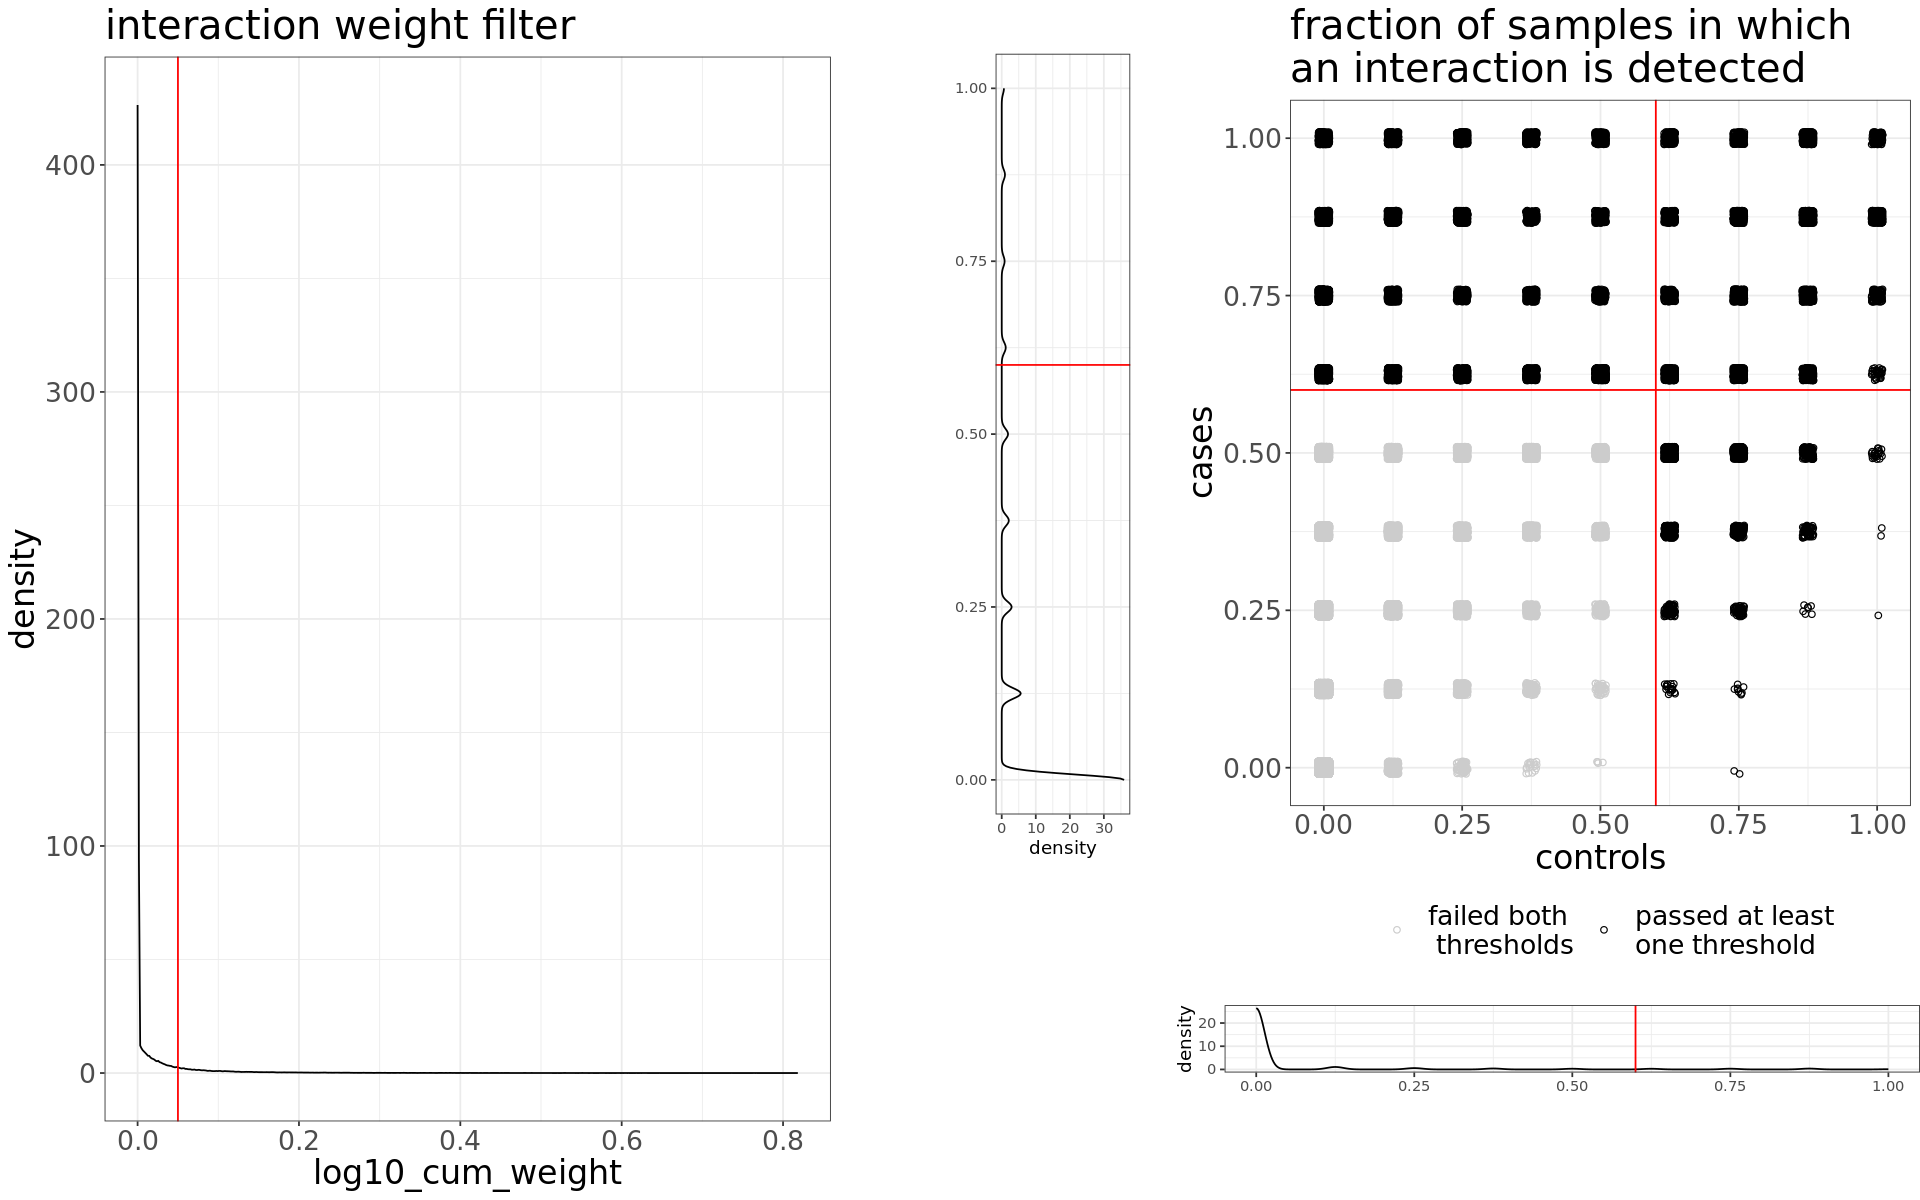

[1] "161157 out of 170688 interactions do not pass the thresholds for log10 cumulative interactions weight > 0.05 and fraction of expressing samples > 0.6 . Also  28864  interactions didn't pass the discrepancy filter.  In total, 161157  bad quality interactions will be removed and 9531 good quality interactions will remain."


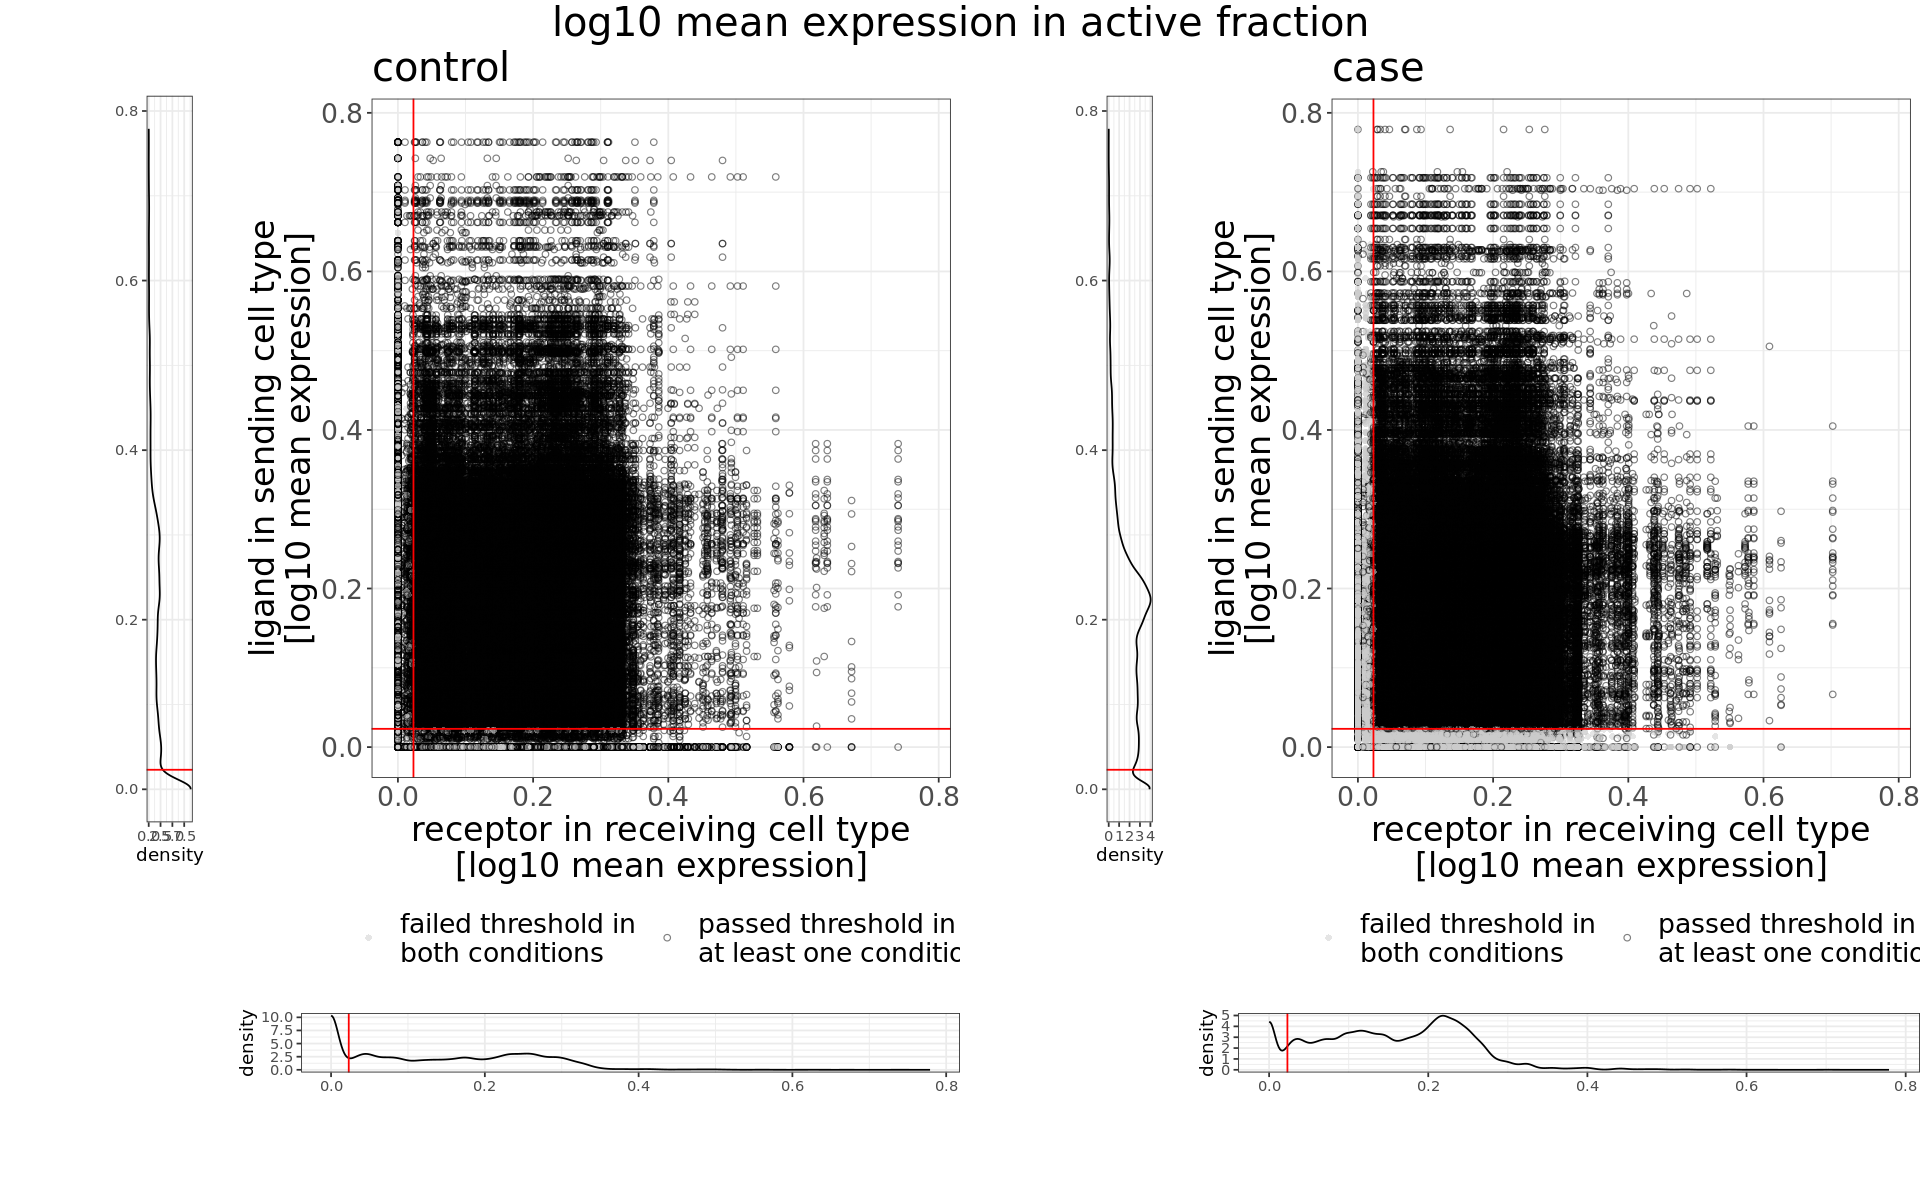

In [21]:
print("filter weak interactions")

options(repr.plot.height = 10
       ,repr.plot.width = 16)
interactions <- filter_interactions(comm_result = interactions
                             ,threshold_frac_samples_per_condition = threshold_frac_samples_per_condition
                             ,threshold_log10_cum_weight = threshold_log10_cum_weight
                             ,threshold_log10_meanexpr_per_condition = threshold_log10_meanexpr_per_condition
)

In [22]:
print(str(interactions$thresholds))
print(str(interactions$anno_interactions))

List of 6
 $ threshold_expr                        : num 0.1
 $ threshold_nr_active_cells             : num 6
 $ threshold_celltype_size               : num 6
 $ threshold_log10_cum_weight            : num 0.05
 $ threshold_frac_samples_per_condition  : num 0.6
 $ threshold_log10_meanexpr_per_condition: num 0.023
NULL
'data.frame':	170688 obs. of  28 variables:
 $ interaction_ID                            : chr  "Epithelial:ADAM12_Epithelial:ITGB1" "Epithelial:ADAM12_Epithelial:SDC4" "Epithelial:ADAM15_Epithelial:ITGA5" "Epithelial:ADAM15_Epithelial:ITGA9" ...
 $ ligand_gene_name                          : chr  "ADAM12" "ADAM12" "ADAM15" "ADAM15" ...
 $ receptor_gene_name                        : chr  "ITGB1" "SDC4" "ITGA5" "ITGA9" ...
 $ sending_cell_type                         : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ receiving_cell_type                       : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ mean_e_s_l_control                 

# Differential Communication

For calculating statistically significant differential interactions between the cases and the controls, we need to define an adjusted p-value threhsold and the log2 fold change threshold. 

In [23]:
# Set up log2 fold change threshold. The default value is 1
threshold_log2FC <- 1
print(paste("[absolute] threshold_log2FC >",threshold_log2FC))

[1] "[absolute] threshold_log2FC > 1"


In [24]:
# Set up FDR threshold. The default value is 0.1
threshold_fdr <- 0.1
print(paste("threshold_fdr <",threshold_fdr))

[1] "threshold_fdr < 0.1"


The `test_diff` function stores the thresholds in the `thresholds` list of the interactions object.

The `test_diff` function calculates a p-value for each interaction using a Wilcoxon test and adjusts for multiple testing using the FDR correction method. After that, the function checks whether the log2 fold change and the adjusted p-value thresholds were passed. An interactoin is considered significant if it passes both threshodls. The `test_diff` function stores the results as boolean vector to the `anno_interactions` list of the interactions object.

In [25]:
print("calculate differential communication")
interactions <- test_diff(comm_result = interactions
                          ,threshold_fdr = threshold_fdr
                          ,which_test = "t-test"
                          ,threshold_log2FC = threshold_log2FC
                          
                         )
print(str(interactions$thresholds))
print(str(interactions$anno_interactions))

[1] "calculate differential communication"
[1] "We have 2708 dignificantly differential interactions"
List of 8
 $ threshold_expr                        : num 0.1
 $ threshold_nr_active_cells             : num 6
 $ threshold_celltype_size               : num 6
 $ threshold_log10_cum_weight            : num 0.05
 $ threshold_frac_samples_per_condition  : num 0.6
 $ threshold_log10_meanexpr_per_condition: num 0.023
 $ threshold_fdr                         : num 0.1
 $ threshold_log2FC                      : num 1
NULL
'data.frame':	170688 obs. of  33 variables:
 $ interaction_ID                            : chr  "Epithelial:ADAM12_Epithelial:ITGB1" "Epithelial:ADAM12_Epithelial:SDC4" "Epithelial:ADAM15_Epithelial:ITGA5" "Epithelial:ADAM15_Epithelial:ITGA9" ...
 $ ligand_gene_name                          : chr  "ADAM12" "ADAM12" "ADAM15" "ADAM15" ...
 $ receptor_gene_name                        : chr  "ITGB1" "SDC4" "ITGA5" "ITGA9" ...
 $ sending_cell_type                         : chr  

# Visualisation

In [26]:
idx_up <- interactions$anno_interactions$log2FC_weights >1
idx_unchanged <- abs(interactions$anno_interactions$log2FC_weights)<=1
idx_down <- interactions$anno_interactions$log2FC_weights < -1
idx_sign <- !is.na(interactions$anno_interactions$sign) & interactions$anno_interactions$sign
idx_good <- interactions$anno_interactions$passed_QC_filter

In [27]:
cell_types <- unique(interactions$anno_cells$cell_type)
print(cell_types)

[1] "Epithelial"  "Fibroblasts" "Endothelial" "Myeloid"     "Mast"       
[6] "T-cells"     "Plasma"      "B-cells"    


### Mean weight of good quality edges

In [28]:
# dir.create("/figures")

              Epithelial Fibroblasts Endothelial     Myeloid         Mast
Epithelial  0.0011143199 0.002810311 0.001368468 0.003514932 0.0008381201
Fibroblasts 0.0021409033 0.043309709 0.021497266 0.038362980 0.0235474171
Endothelial 0.0010765456 0.022965128 0.011831006 0.019828711 0.0112975520
Myeloid     0.0034647699 0.050986757 0.020091948 0.050538540 0.0320606581
Mast        0.0005325562 0.024372942 0.009044952 0.020140479 0.0153968492
T-cells     0.0016270462 0.066928553 0.031230660 0.055463266 0.0378475454
Plasma      0.0088167361 0.032363991 0.019643365 0.029925631 0.0189960174
B-cells     0.0004110370 0.014560398 0.004809898 0.009697346 0.0018759208
               T-cells      Plasma      B-cells
Epithelial  0.00264011 0.008568842 0.0004206034
Fibroblasts 0.06926793 0.029368537 0.0164323307
Endothelial 0.03910336 0.017937954 0.0069199098
Myeloid     0.07469209 0.034722595 0.0126674194
Mast        0.03748133 0.015438716 0.0017569401
T-cells     0.10664600 0.037741159 0.016242116

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


            Epithelial Fibroblasts Endothelial     Myeloid       Mast
Epithelial  0.03551854 0.025008765 0.024603297 0.024036531 0.03971978
Fibroblasts 0.02302351 0.026978387 0.031488866 0.021635884 0.05084511
Endothelial 0.02313867 0.029978892 0.038207175 0.025593058 0.05769385
Myeloid     0.02357430 0.020080539 0.024669022 0.021563015 0.03872780
Mast        0.03660196 0.036431636 0.046418280 0.029295303 0.08499641
T-cells     0.02929963 0.015392421 0.022742050 0.020266384 0.06218500
Plasma      0.01755944 0.006976912 0.007367234 0.008611928 0.01580000
B-cells     0.02220791 0.010501883 0.015289635 0.021036028 0.03503058
               T-cells      Plasma    B-cells
Epithelial  0.03427922 0.016090483 0.03139276
Fibroblasts 0.01954099 0.007319272 0.01248221
Endothelial 0.02709399 0.007033170 0.01486552
Myeloid     0.02484022 0.008323051 0.02345659
Mast        0.05292915 0.011892938 0.02951894
T-cells     0.05405568 0.012809460 0.05373776
Plasma      0.01633512 0.008373439 0.02314940
B-

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


[[1]]
png 
  2 

[[2]]
png 
  2

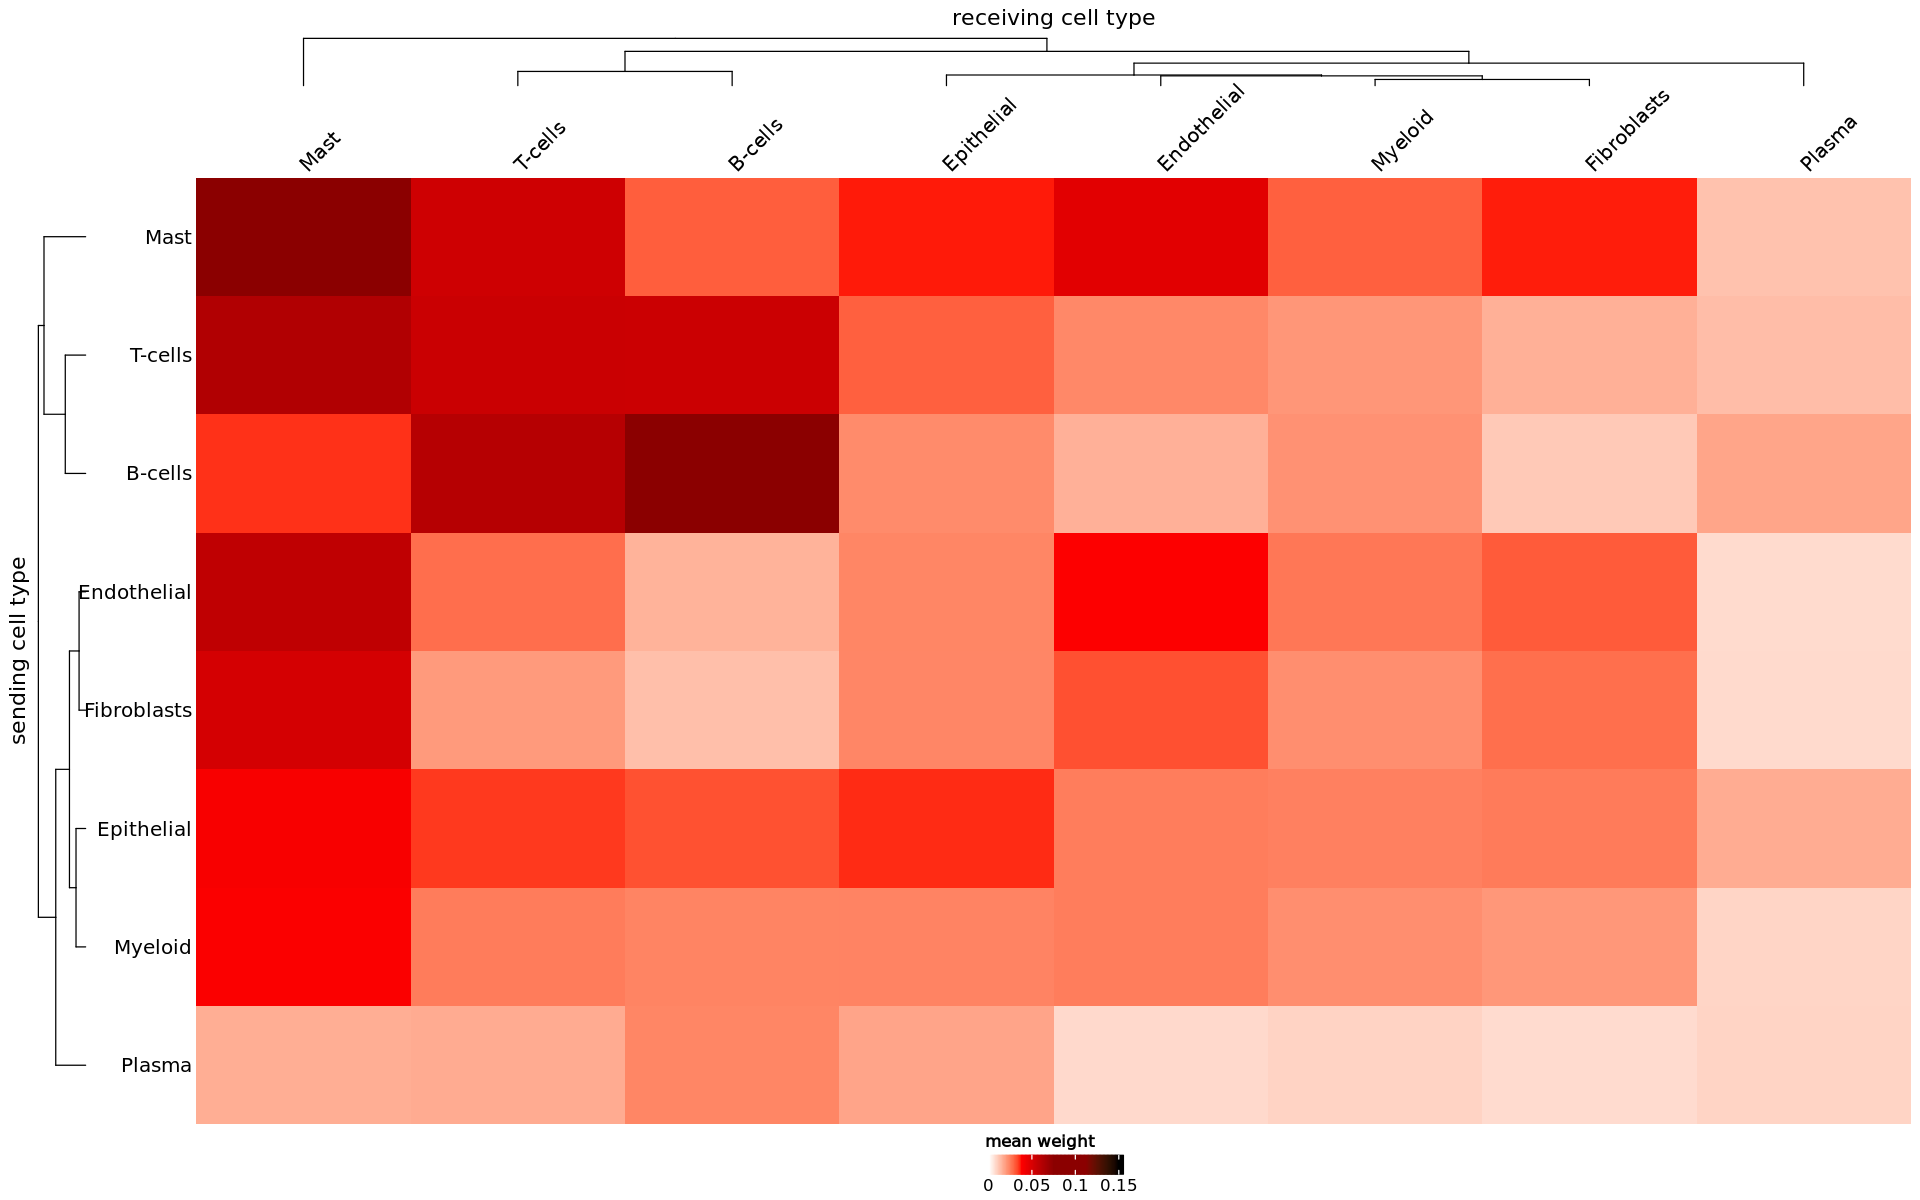

In [29]:
# heatmap of total weight of good interactions
lapply(c(unique(interactions$anno_samples$region))
      ,function(hs){
          
          idx_hs <- interactions$anno_samples$region == hs
          
          # number of interactions as heatmap
    df <- as.data.frame(matrix(,nrow = length(cell_types)
                              ,ncol = length(cell_types)
                              )
                       )
    rownames(df) <- cell_types
    colnames(df) <- cell_types

    # populate the data frame
    for(send in cell_types){
        idx_send <- interactions$anno_interactions$sending_cell_type == send

        for(rec in cell_types){
            idx_rec <- interactions$anno_interactions$receiving_cell_type == rec

            #print(send)
            #print(rec)
            #print(head(interactions$anno_interactions[idx_good & idx_send & idx_rec,c("interaction_ID"
            #                                                                          ,"log2FC_weights"
            #                                                                          , "sign")]))
            #print(sum(idx_good & idx_send & idx_rec))

            weights <- interactions$weights[idx_good & idx_send & idx_rec,idx_hs]
            #ifelse(length(weights) == 0
            #      ,df[send,rec] <- 0
                 # ,
            df[send,rec] <- mean(unlist(weights))
             #     )
            

        }
    }

    print(df)

    my_color <-  colorRamp2(seq(0
                                , 0.15 #max(df)
                                , length = 5)
                            , c("white", "red", "red4",  "darkred", "black"))

    h <- Heatmap(df
                 ,name = "mean weight"
                 ,heatmap_legend_param = list(direction = "horizontal")
                 ,column_names_side = "top"
                 ,row_names_side = "left"
                 ,col = my_color
                 ,column_title = "receiving cell type"
                 ,row_title = "sending cell type"
                 #,cluster_columns=FALSE
                 #,cluster_rows=FALSE
                 #,row_order = c("HSPC", "DC", "Mono", "Ery", "B", "T")
                 #,column_order = c("HSPC","DC", "Mono", "Ery", "B", "T")
                 ,column_names_rot = 45
                )
          ComplexHeatmap::draw(h
             ,heatmap_legend_side = "bottom")

    pdf(file=paste0("figures/heatmap_cellTypes_meanWeight_h_"
                    ,hs
                    ,".pdf"))
         ComplexHeatmap::draw(h
             ,heatmap_legend_side = "bottom")
           dev.off()
      })

### Volcano plot

We can now visualize the interactions with a volcano plot. 

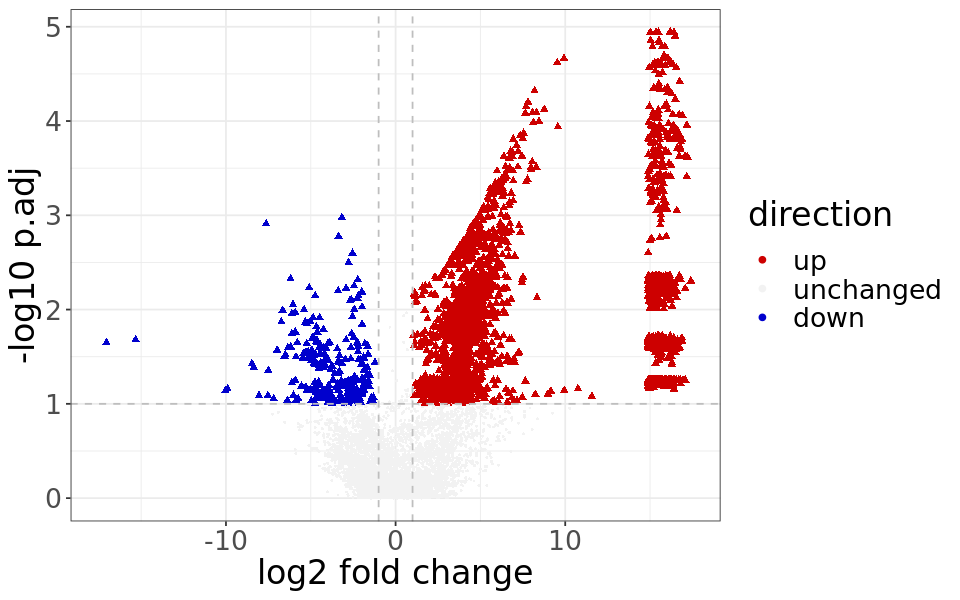

In [30]:
# volcano plot
options(repr.plot.height = 5
       ,repr.plot.width = 8)

df <- data.frame(log2FC = interactions$anno_interactions$log2FC_weights[idx_good]
                 ,y = -log10(interactions$anno_interactions$p.adj[idx_good])
                 ,significant = interactions$anno_interactions$sign[idx_good]
                )

df$direction <- "unchanged"
df$direction[df$significant & (df$log2FC > 1)] <- "up"
df$direction[df$significant & (df$log2FC < -1)] <- "down"
df$direction <- factor(df$direction
                      ,levels = c("up"
                                 ,"unchanged"
                                 ,"down")
                      ,ordered = TRUE)

xlab <- "log2 fold change"
ylab <- "-log10 p.adj"

xlim <- c(-max(abs(df$log2FC))
          ,max(abs(df$log2FC))
         )
ylim <- c(0, max(df$y))

p <- ggplot(data = df
            ,aes(x = log2FC
                 ,y = y
                 ,color = direction
                 ,size = significant
                 ,shape = significant
                ))+
geom_point()+
scale_color_manual(values = c("red3"
                               ,"gray95"
                               ,"blue3"))+
scale_size_manual(values = c(0.5, 1.5))+
guides(size = "none"
      ,shape = "none")+
xlab(xlab)+
ylab(ylab)+
xlim( xlim )+
ylim(ylim)+
theme_bw()+
theme(text = element_text(size=20))+
geom_vline(xintercept = interactions$thresholds$threshold_log2FC
          ,lty = 2
          ,color = "gray")+
geom_vline(xintercept = -interactions$thresholds$threshold_log2FC
          ,lty = 2
          ,color = "gray")+
geom_hline(yintercept = -log10(interactions$thresholds$threshold_fdr)
          ,lty = 2
          ,color = "gray")
p




    up unchanged down
1 2417      6823  291


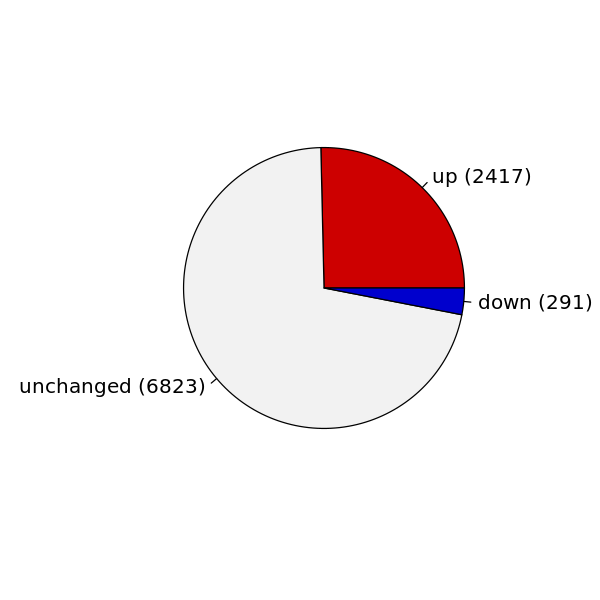

In [31]:
# pie chart
df <- data.frame(up = sum(idx_good & idx_sign & idx_up)
                ,unchanged = sum(idx_good & !idx_sign)
                , down = sum(idx_good & idx_sign & idx_down)
                )
print(df)

options(repr.plot.width = 5
       ,repr.plot.height = 5)
pie(unlist(df)
   ,labels = paste0(colnames(df)," (",unlist(df), ")")
   ,col = c("red3"
           ,"gray95"
           ,"blue3")) 

### Heatmap of top differential interactions

In [32]:
# heatmap of interactions weight of top differential interactions
# top adjusted p value
idx_topsign <- interactions$anno_interactions$p.adj %in% unique(sort(interactions$anno_interactions$p.adj))[1:500]
# all upregulated interactions
idx_topup <- interactions$anno_interactions$log2FC_weights > 1 & idx_topsign

# top 20 downregulated interactions
idx_topdown <- interactions$anno_interactions$log2FC_weights < -1 & idx_topsign
idx_topdown20 <- interactions$anno_interactions$interaction_ID %in% interactions$anno_interactions$interaction_ID[idx_topdown][1:20]

idx <- idx_topup | idx_topdown20
print(sum(idx))

[1] 862


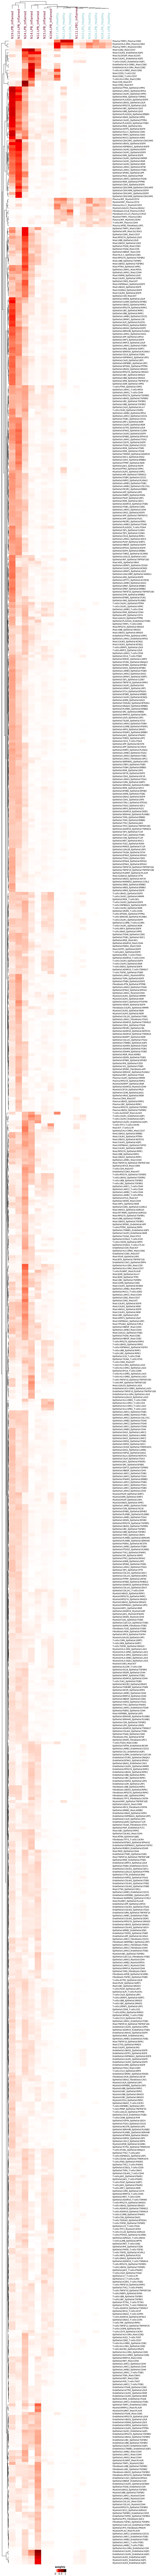

In [33]:
set.seed(1)
options(repr.plot.height = 140
       ,repr.plot.width = 8.5)
plot_heatmap(interactions
            ,which_interactions = idx
            ,values_to_plot = "weights")

#### Individual parameters

    cell_type log2FC_rho
1  Epithelial  2.3998233
8     B-cells  1.9614984
5        Mast  1.0253842
3 Endothelial  0.4767822
6     T-cells -0.5218688
2 Fibroblasts -0.8063247
4     Myeloid -0.8375680
7      Plasma -1.2598897


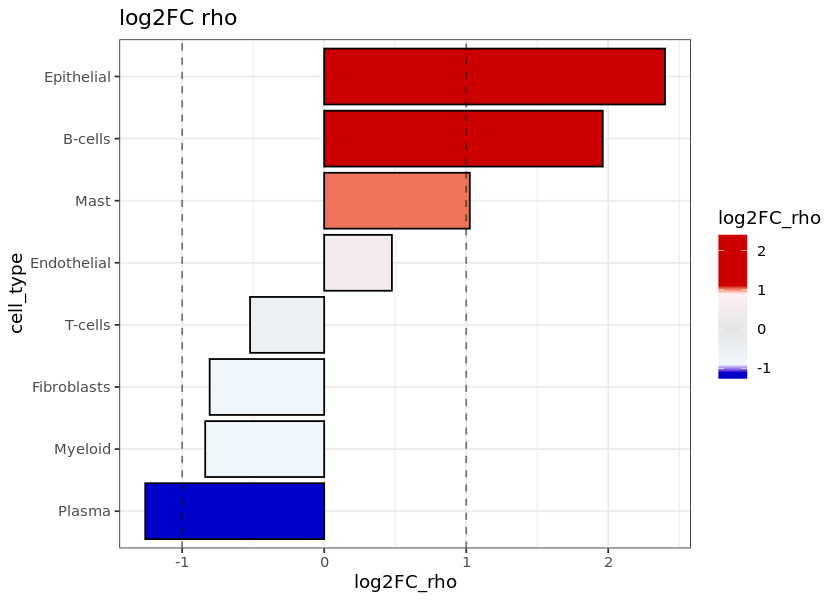

In [34]:
# plot log2FC rho for cell types
df <- data.frame(cell_type = cell_types)
df$log2FC_rho <- sapply(cell_types
                       ,function(ct){
                           idx_ct <- interactions$anno_interactions$sending_cell_type == ct # just take the sending
                         interactions$anno_interactions$log2FC_rho_s[idx_ct][1] # just take the first one
                       })
df <- df[order(df$log2FC_rho,decreasing = TRUE),]
df$cell_type <- factor(df$cell_type
                         ,levels = df$cell_type
                         ,ordered = TRUE)
print(df)

my_values <- c(min(df$log2FC_rho),-1.1,-0.9,0,0.9,1.1,max(df$log2FC_rho))
my_colors <- c("blue3","blue3","aliceblue","gray90","lavenderblush","red3","red3")
names(my_colors) <- my_values
resc_values <- rescale(as.numeric(names(my_colors)))

options(repr.plot.width = 7
       ,repr.plot.height = 5)
ggplot(data = df
      ,aes(x = cell_type
          ,y = log2FC_rho
          ,fill = log2FC_rho)
      )+
geom_col(color = "black")+
scale_fill_gradientn(colours = my_colors
                           ,values = resc_values
                          )+
geom_hline(yintercept = c(-1,1)
          ,lty = 2
          ,lwd = 0.5
          ,alpha = 0.5)+
ggtitle("log2FC rho")+
scale_x_discrete(limits = rev)+ # reverse order on the x axis
coord_flip()+
theme_bw()

'data.frame':	137389 obs. of  2 variables:
 $ cell_type: Ord.factor w/ 8 levels "Epithelial"<"Fibroblasts"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ log2FC   : Ord.factor w/ 3 levels "log2FC > 1"<"unchanged"<..: 1 1 1 1 1 1 1 1 1 1 ...
NULL


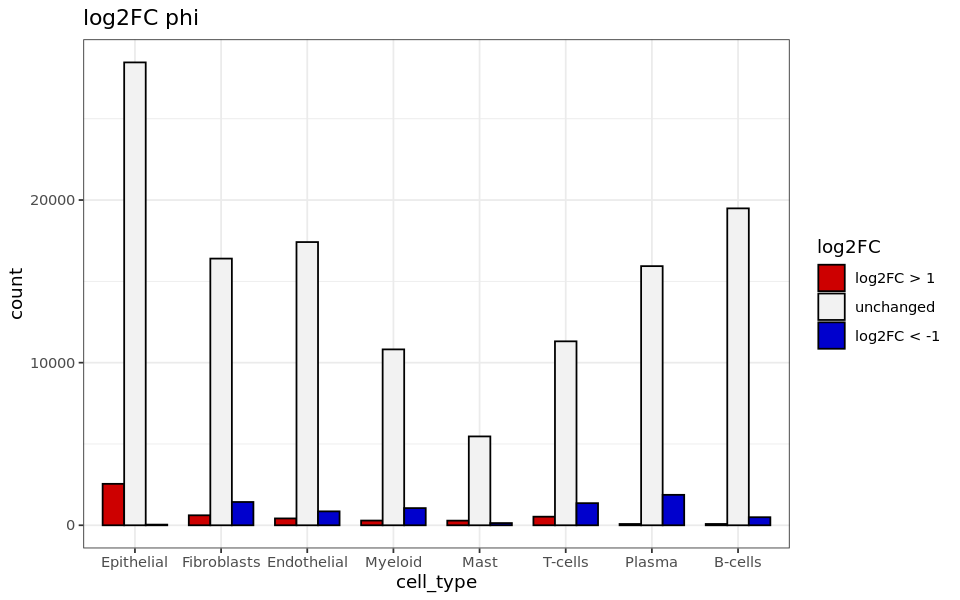

In [35]:
# phi log2FC by cell type
df <- lapply(c("up"
                    ,"unchanged"
                    ,"down")
                   ,function(dir){
                       if(dir == "up"){
                           idx_send <-interactions$anno_interactions$log2FC_phi_s_l > 1 & idx_good
                           idx_rec <- interactions$anno_interactions$log2FC_phi_r_r > 1 & idx_good
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       }else if(dir == "down"){
                           idx_send <-interactions$anno_interactions$log2FC_phi_s_l < -1 
                           idx_rec <- interactions$anno_interactions$log2FC_phi_r_r < -1
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       } else {
                           idx_send <- abs(interactions$anno_interactions$log2FC_phi_s_l) > 1 
                           idx_rec <- abs(interactions$anno_interactions$log2FC_phi_r_r) > 1
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       }
                       
                   }
                       )
df <- rbind(df[[1]],df[[2]],df[[3]])
df$cell_type <- factor(df$cell_type
                         ,levels = c(unique(anno_cells$cell_type))
                         ,ordered = TRUE)
df$log2FC <- factor(df$log2FC
                      ,levels = c("up"
                                 ,"unchanged"
                                 ,"down")
                       ,labels = c("log2FC > 1"
                                  ,"unchanged"
                                  ,"log2FC < -1")
                      ,ordered = TRUE)
print(str(df))

           
options(repr.plot.width = 8
       ,repr.plot.height = 5)
p <- ggplot(data = df
          ,aes(x = cell_type
               ,fill = log2FC
              )
           )+
    geom_bar(position = "dodge"
            ,width=.75
            ,color = "black")+
scale_fill_manual(values = c("red3","gray95","blue3"))+
    ggtitle("log2FC phi")+
    #ylim(c(0,3500))+
    theme_bw()

p

'data.frame':	134335 obs. of  2 variables:
 $ cell_type: Ord.factor w/ 8 levels "Epithelial"<"Fibroblasts"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ log2FC   : Ord.factor w/ 3 levels "log2FC > 1"<"unchanged"<..: 1 1 1 1 1 1 1 1 1 1 ...
NULL


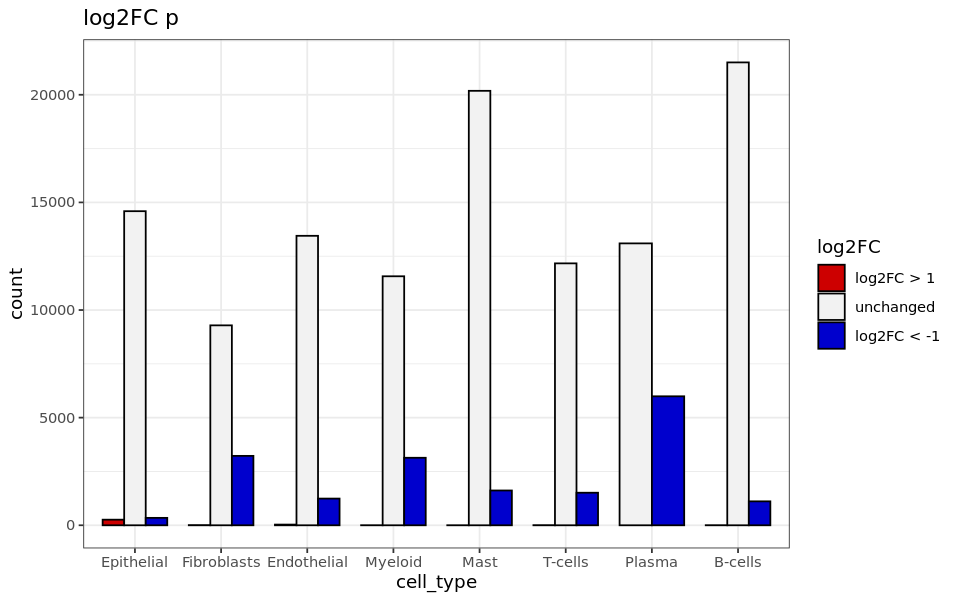

In [36]:
# phi log2FC by cell type
df <- lapply(c("up"
                    ,"unchanged"
                    ,"down")
                   ,function(dir){
                       if(dir == "up"){
                           idx_send <-interactions$anno_interactions$log2FC_p_s_l > 1 & idx_good
                           idx_rec <- interactions$anno_interactions$log2FC_p_r_r > 1 & idx_good
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       }else if(dir == "down"){
                           idx_send <-interactions$anno_interactions$log2FC_p_s_l < -1 
                           idx_rec <- interactions$anno_interactions$log2FC_p_r_r < -1
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       } else {
                           idx_send <- abs(interactions$anno_interactions$log2FC_p_s_l) > 1 
                           idx_rec <- abs(interactions$anno_interactions$log2FC_p_r_r) > 1
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       }
                       
                   }
                       )
df <- rbind(df[[1]],df[[2]],df[[3]])
df$cell_type <- factor(df$cell_type
                         ,levels = c(unique(anno_cells$cell_type))
                         ,ordered = TRUE)
df$log2FC <- factor(df$log2FC
                      ,levels = c("up"
                                 ,"unchanged"
                                 ,"down")
                    ,labels = c("log2FC > 1"
                               ,"unchanged"
                               ,"log2FC < -1")
                      ,ordered = TRUE)
print(str(df))

           
options(repr.plot.width = 8
       ,repr.plot.height = 5)
p <- ggplot(data = df
          ,aes(x = cell_type
               ,fill = log2FC
              )
           )+
    geom_bar(position = "dodge"
            ,width=.75
            ,color = "black")+
scale_fill_manual(values = c("red3","gray95","blue3"))+
    ggtitle("log2FC p")+
    #ylim(c(0,3500))+
    theme_bw()

p

### Classes of interactions

In this section, we will check which of the individual components (rho, phi, p) are driving the change of the interactions. For this, we will combine following forest plots: 
- log2 fold change of the interaction weight (`w`)
- log2 fold change of the cell type abundance of the sending cell type (`rho_s`)
- log2 fold change of the active fraction of the sending cell type expressing the ligand (`phi_s_l`)
- log2 fold change of the expression of the sending cell type expressing the ligand (`p_s_l`)
- log2 fold change of the cell type abundance of the receiving cell type (`rho_r`)
- log2 fold change of the active fraction of the receiving cell type expressing the receptor (`phi_r_r`)
- log2 fold change of the expression of the receiving cell type expressing the receptor (`p_r_r`)

We will first explore the interaction that were unchanged. We will start with the interactions that had a trully unchanged log2 fold change of the weight (i.e. -1 < `log2FC_weight` < 1), and then plot the interactions with eigther up- or down-regulated log2 fold change of the weight, which though didn't pass the adjusted p-value threshold.

#### Unchanged

In [37]:
idx_of_interest <- !idx_sign & idx_good
sum(idx_of_interest)

[1] 6823

 No log2FC of the w.

In [38]:
idx_w <- abs(interactions$anno_interactions$log2FC_weights) < 1
sum(idx_of_interest & idx_w)

[1] 2454

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "1139 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "431 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "108 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "559 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "19 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "6 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "3 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "143 interactions"
[1] "rho" "one" "phi" "one" "p"   "one"
[1] "6 int

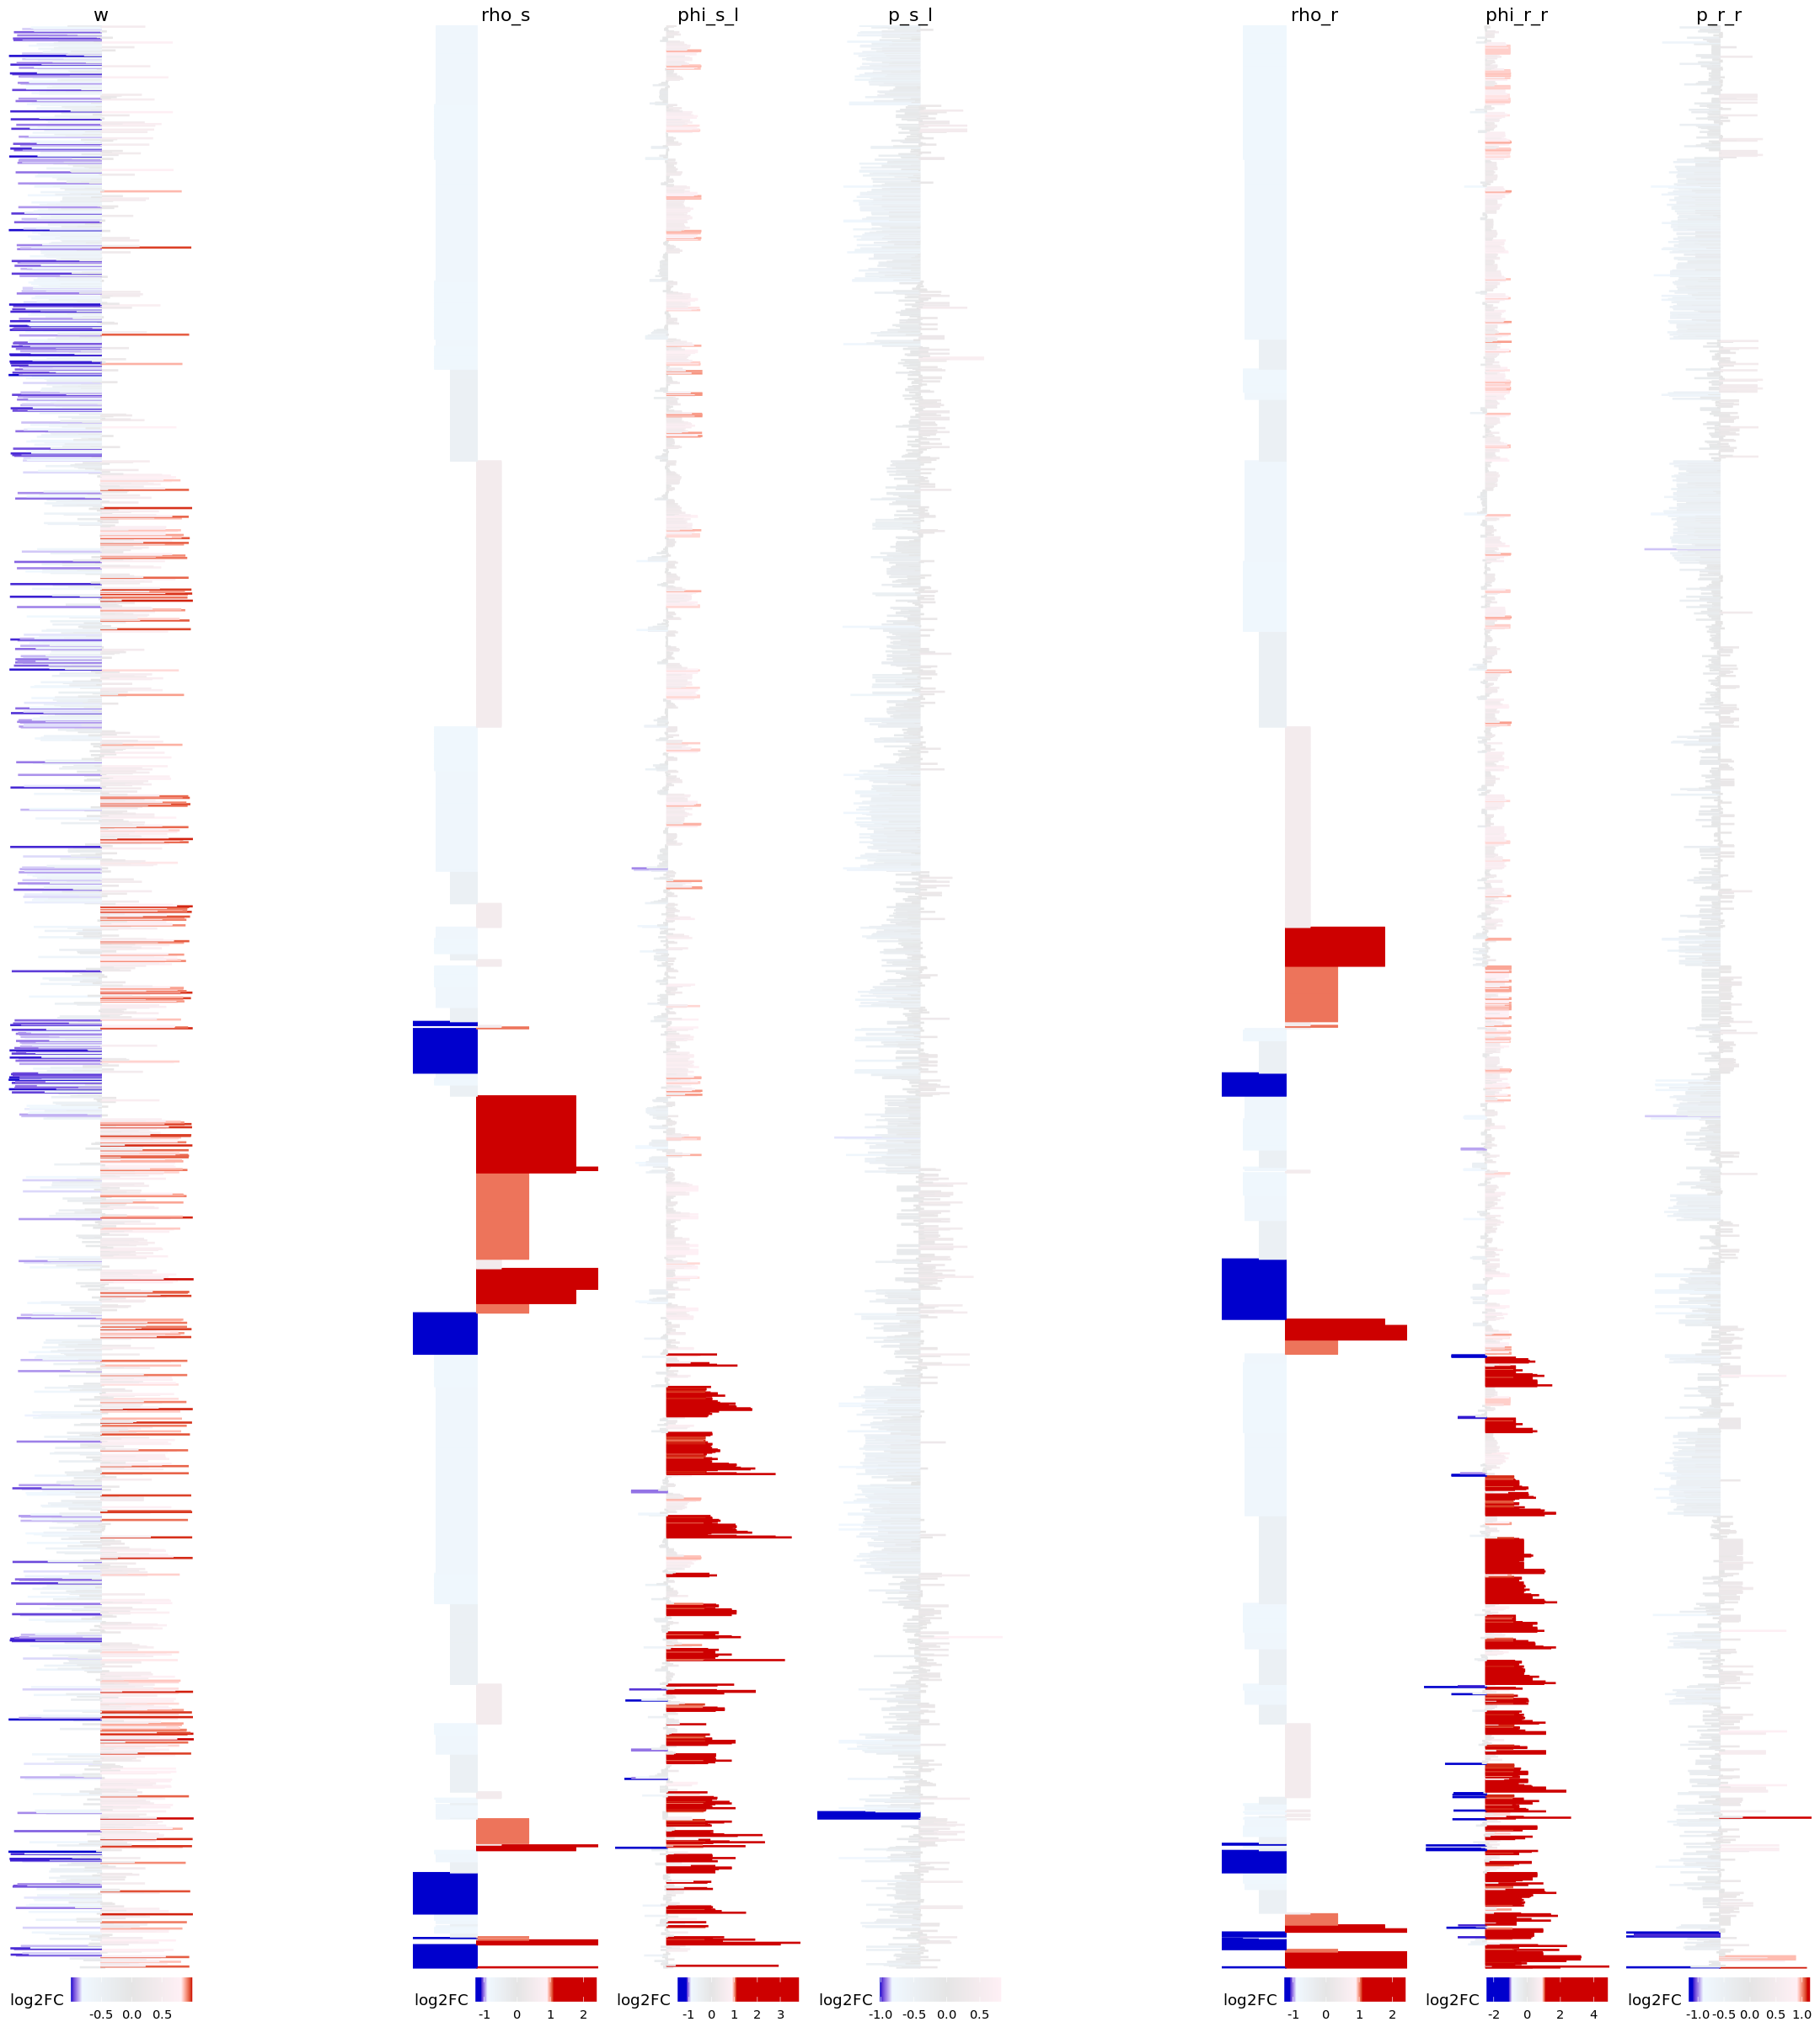

In [39]:
options(repr.plot.height = 20
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest & idx_w
                ,my_anno_interactions = interactions$anno_interactions)

<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>

ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

Log2FC of w > 1, but is not significant.

In [40]:
idx_w <- interactions$anno_interactions$log2FC_weights > 1
sum(idx_of_interest & idx_w)

[1] 1819

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "160 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "554 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "101 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "385 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "63 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "8 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "2 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "392 interactions"
[1] "rho" "one" "phi" "one" "p"   "one"
[1] "8 inte

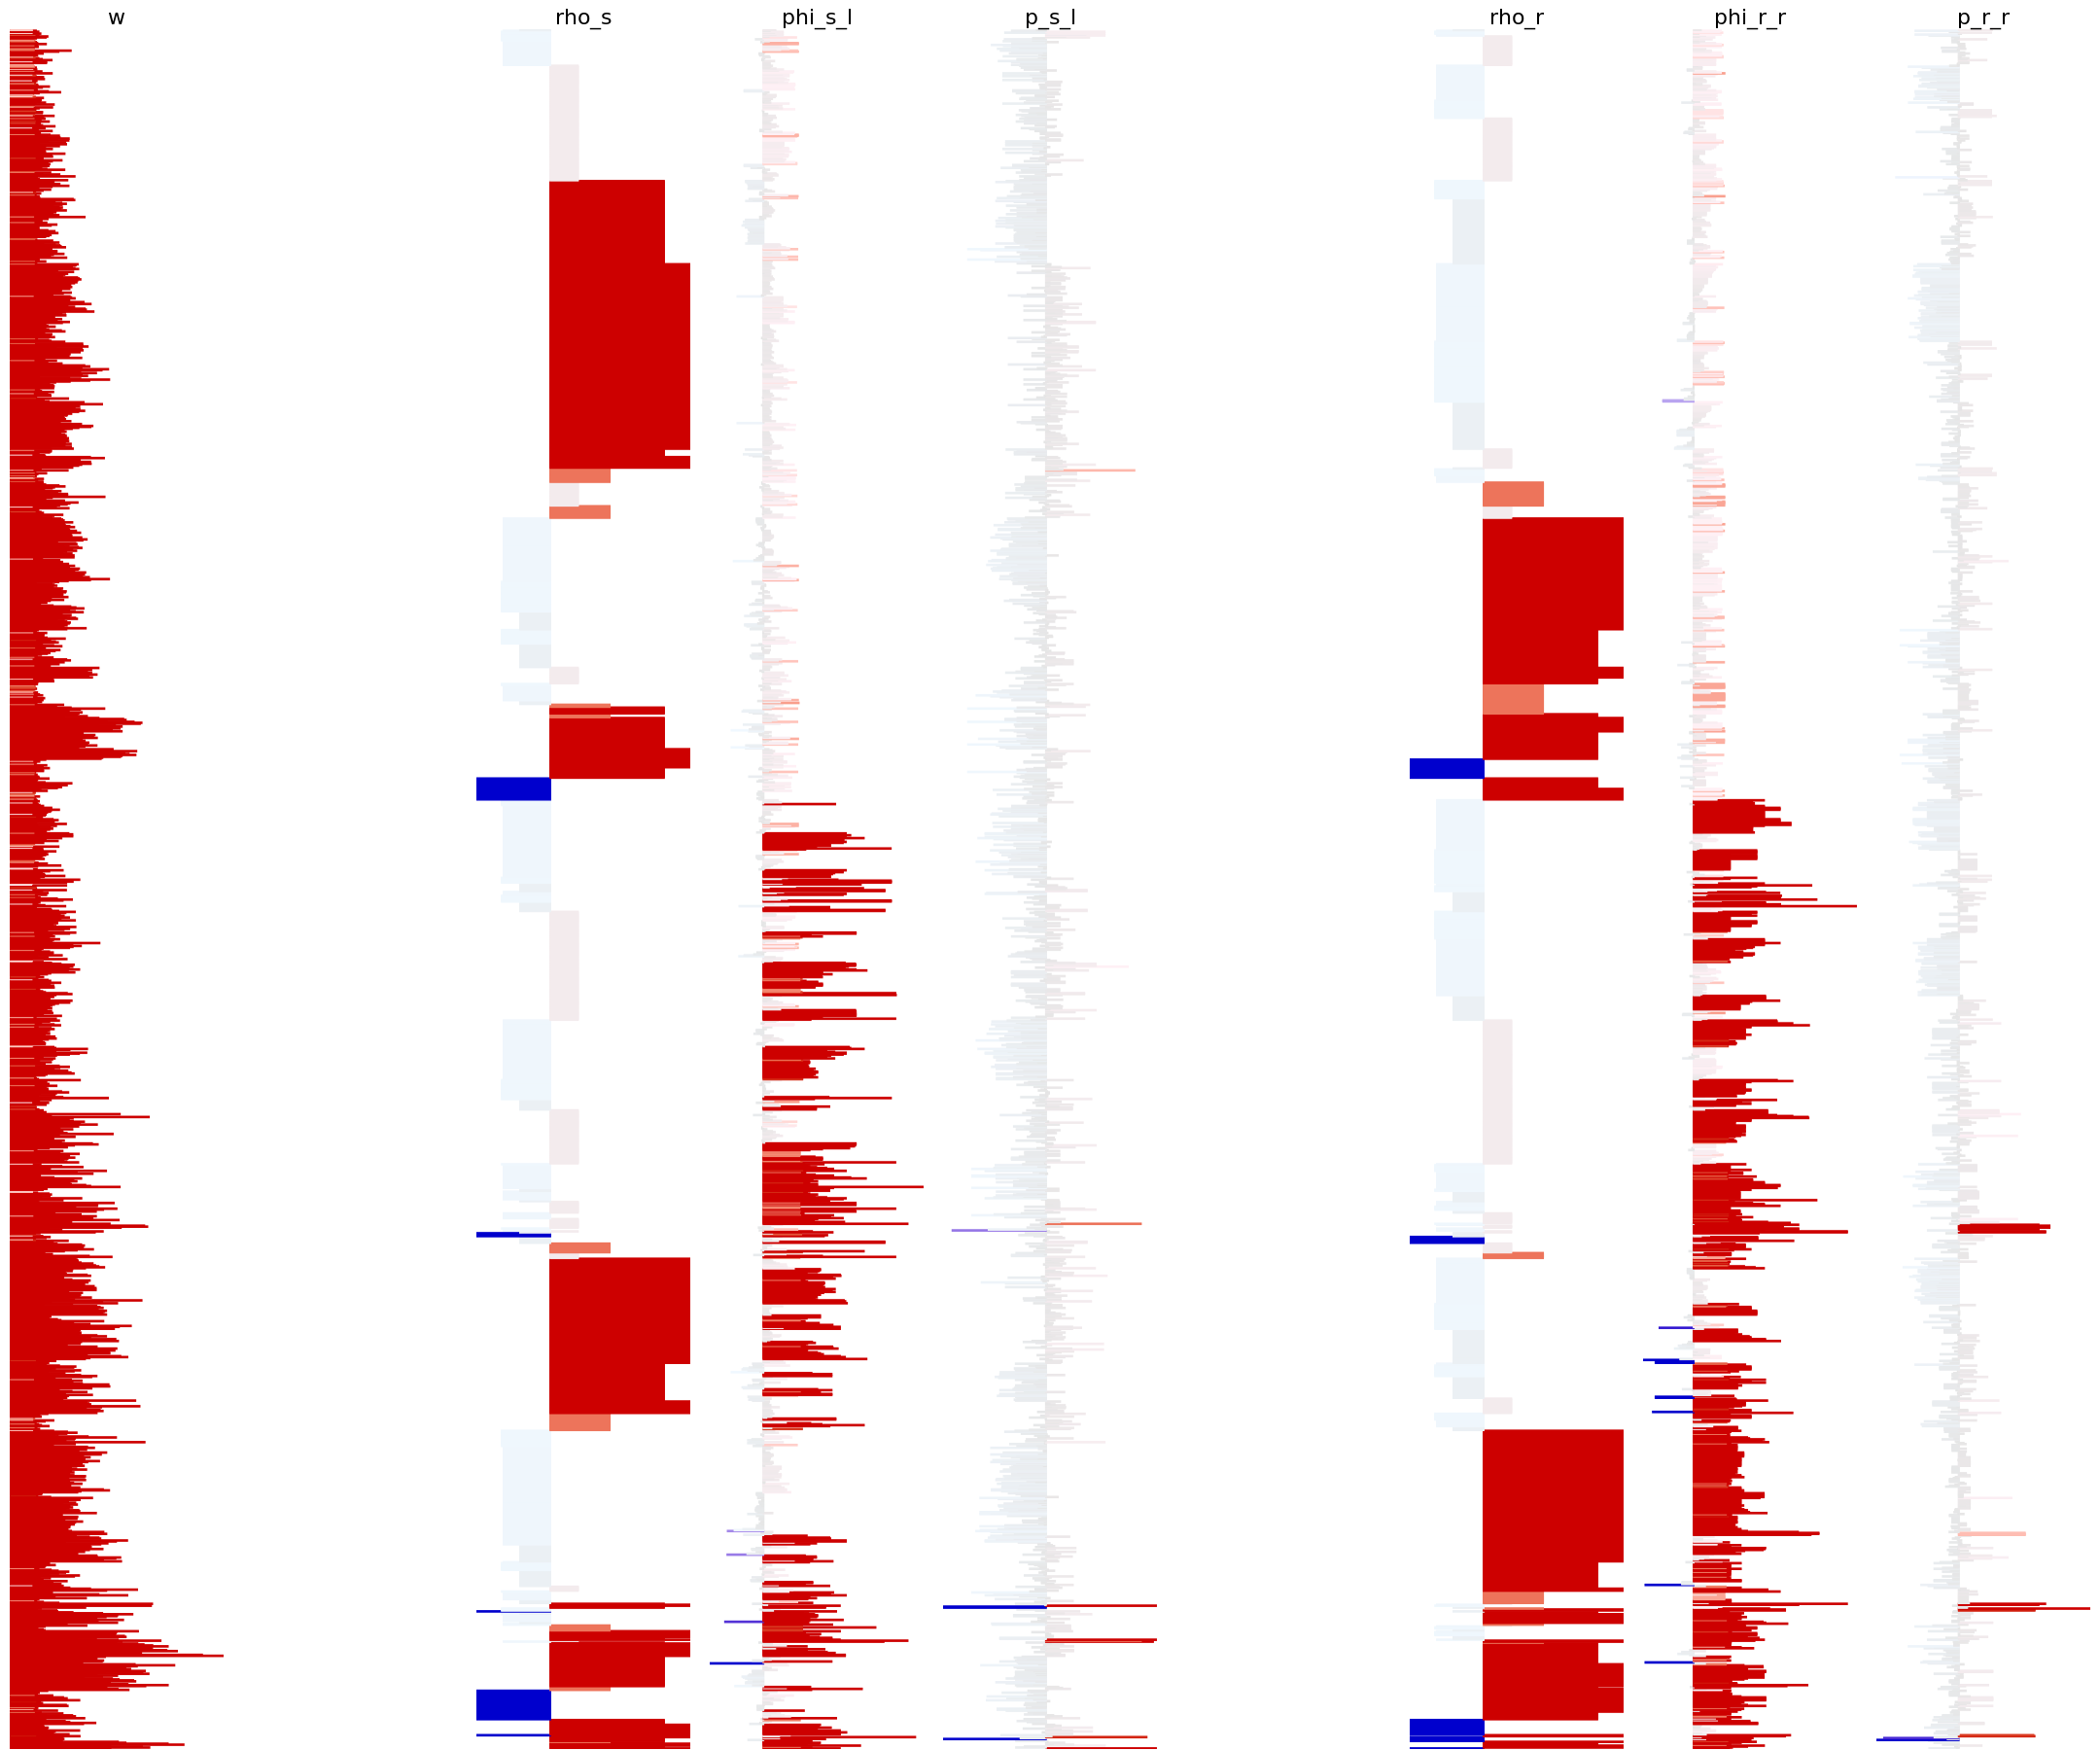

In [41]:
options(repr.plot.height = 15
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest & idx_w
                ,my_anno_interactions = interactions$anno_interactions, plot_legend=FALSE)

<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>

ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

Log2FC of w < -1, but is not significant.

In [42]:
idx_w <- interactions$anno_interactions$log2FC_weights < -1
sum(idx_of_interest & idx_w)

[1] 2550

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "1494 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "592 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "63 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "281 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "14 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "2 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "4 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "5 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "77 interactions"
[1] "rho" "one" "phi" "one" "p"   "one"
[1] "3 inter

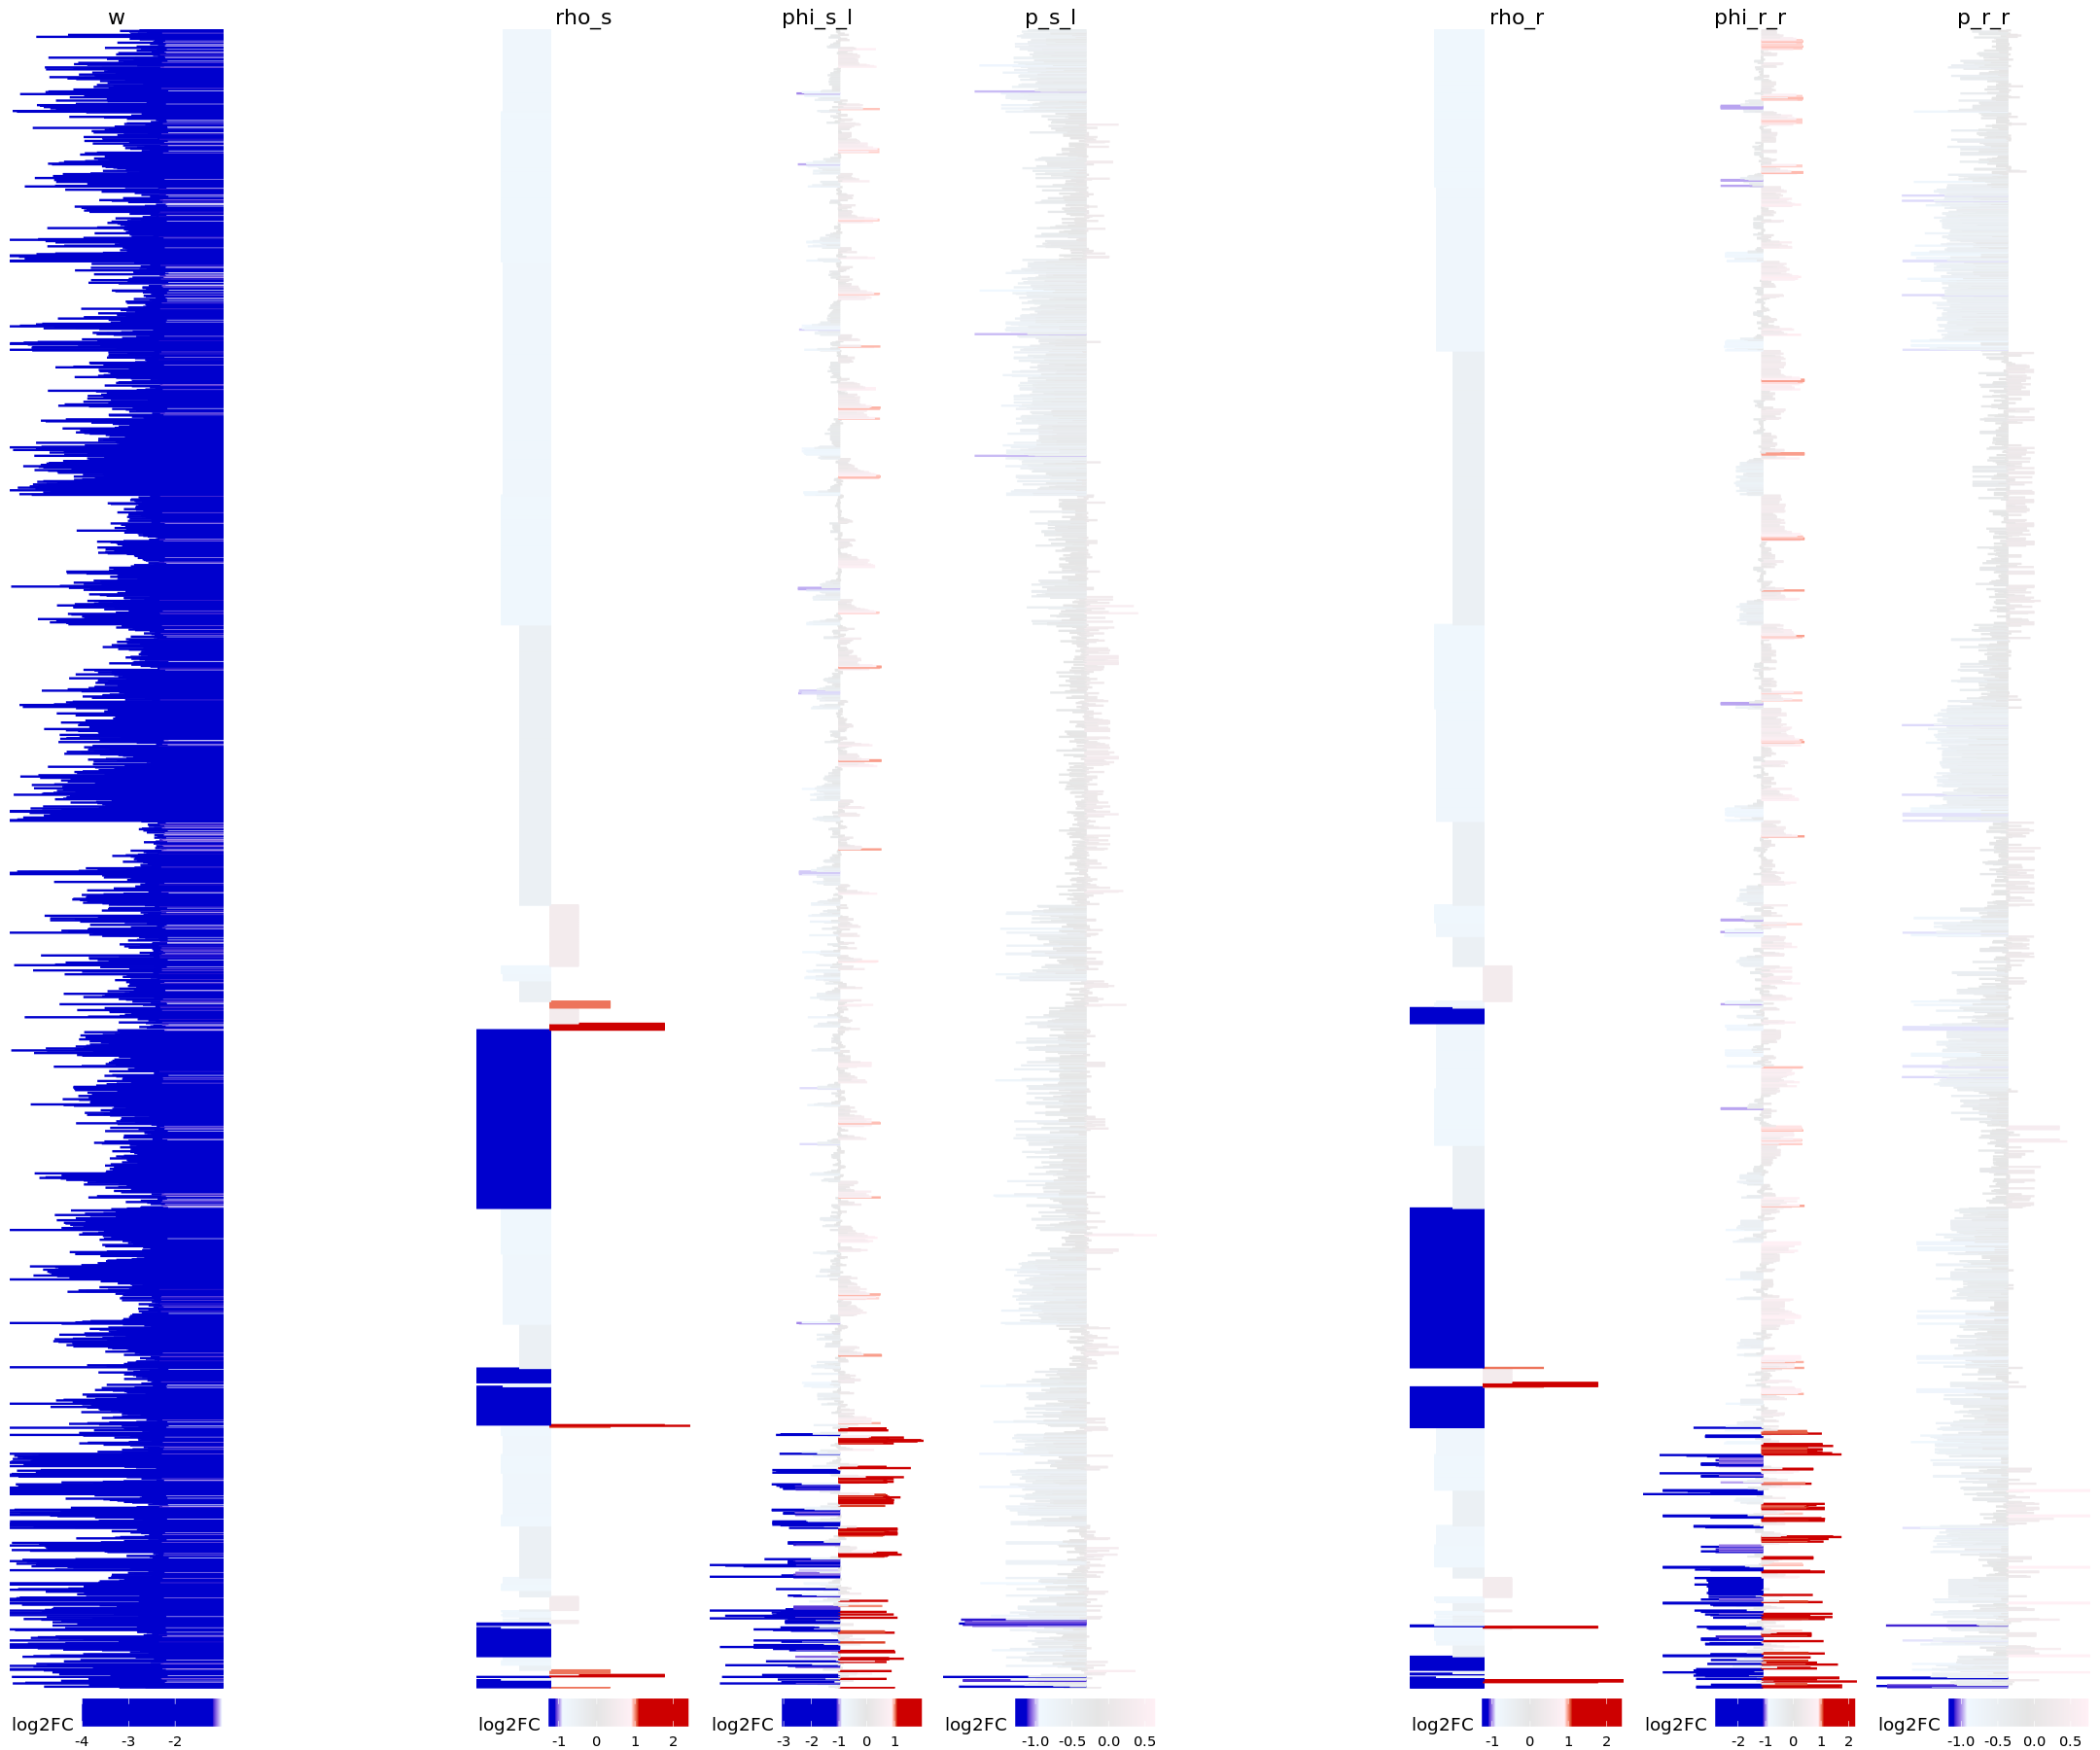

In [43]:
options(repr.plot.height = 15
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest & idx_w
                ,my_anno_interactions = interactions$anno_interactions)

<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>


ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

#### Up-regulated

Now we will explore the interactions in which the `log2FC_weights` passed the upper log2 fold change threshodl, but didn't pass the adjusted p-value threshold.

In [44]:
idx_of_interest <- idx_good & idx_sign & idx_up
sum(idx_of_interest)

[1] 2417

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "147 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "71 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "82 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "11 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "16 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "2 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "938 interactions"
[1] "rho" "one" "phi" "one" "p"   "one"
[1] "99 intera

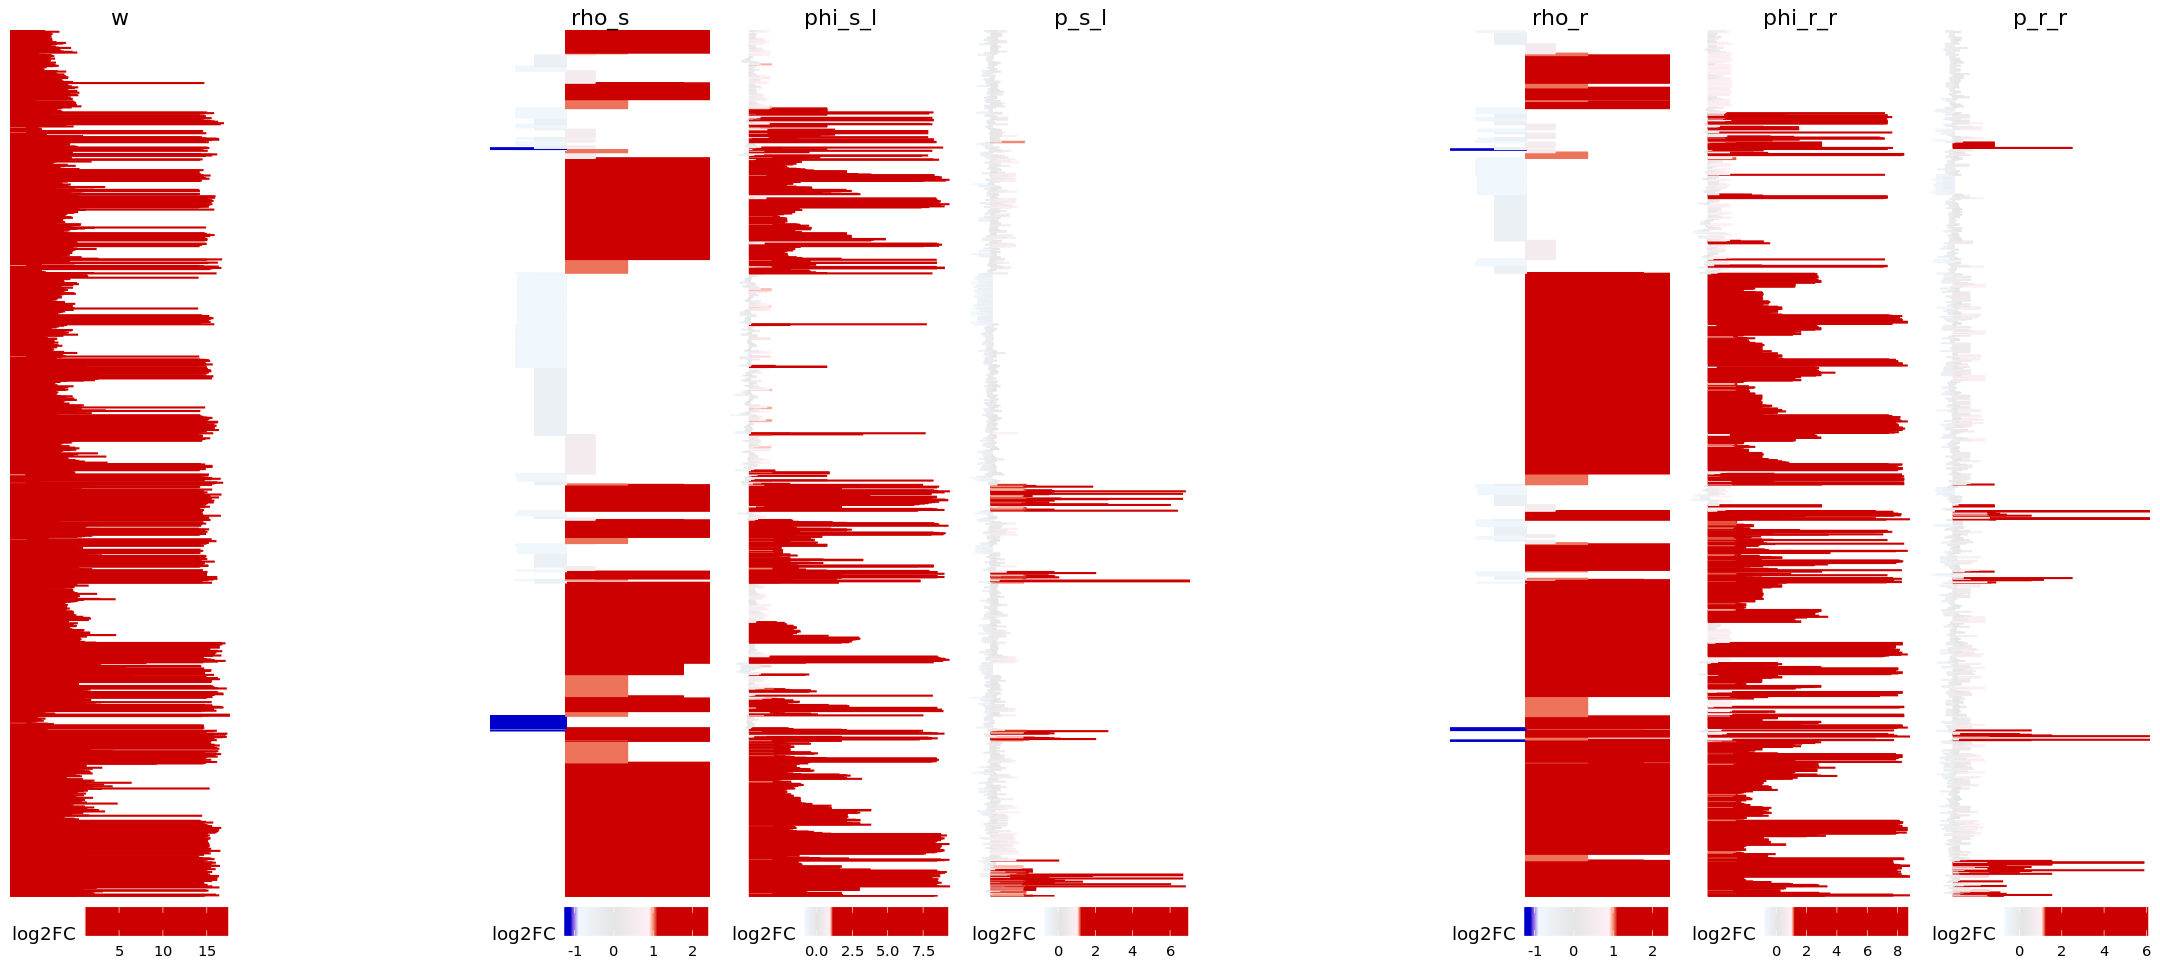

In [45]:
options(repr.plot.height = 8
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest
                ,my_anno_interactions = interactions$anno_interactions)

<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>


ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

#### Down-regulated

Here we will explore the interactions in which the `log2FC_weights` passed the lower log2 fold change threshodl, but didn't pass the adjusted p-value threshold.

In [46]:
idx_of_interest <- idx_good & idx_sign & idx_down
sum(idx_of_interest)

[1] 291

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "76 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "89 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "9 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "82 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "4 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "8 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "19 interactions"
[1] "rho" "one" "phi" "one" "p"   "one"
[1] "3 interaction

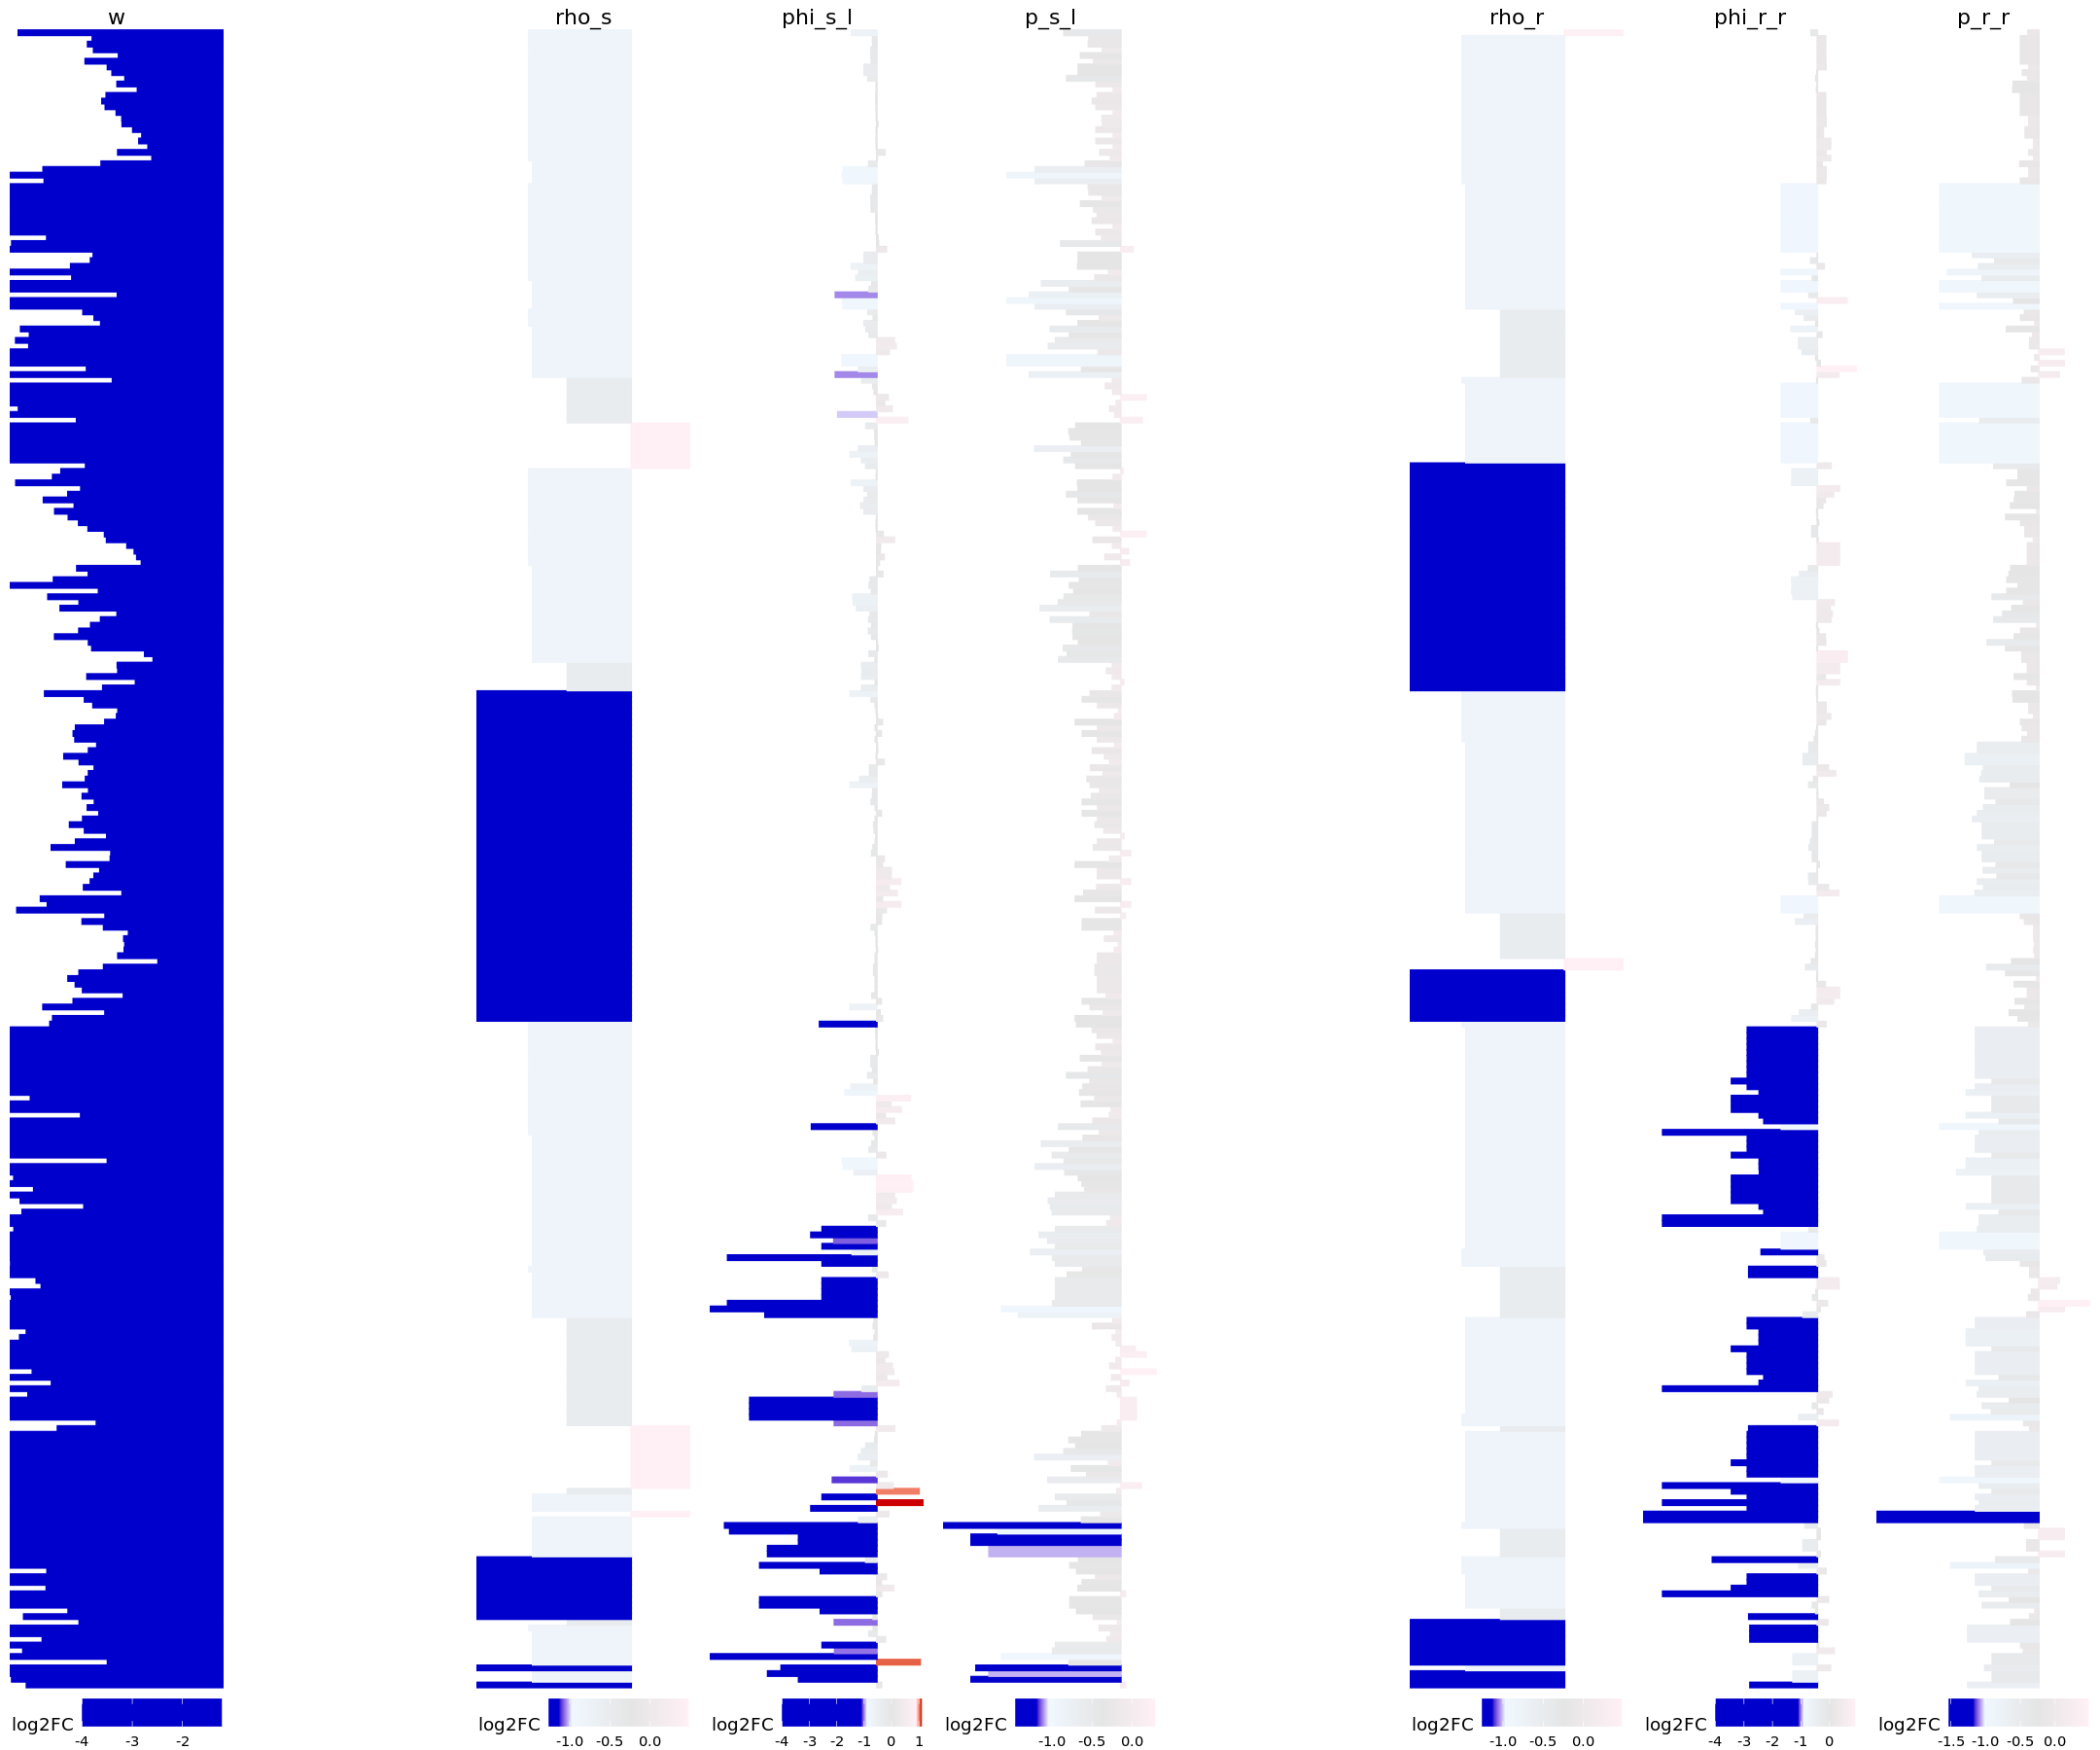

In [47]:
options(repr.plot.height = 15
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest
                ,my_anno_interactions = interactions$anno_interactions)

<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>


ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

### Heatmap number of differential interactions

[1] "Epithelial"
[1] "Epithelial"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "Fibroblasts"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "Endothelial"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "Myeloid"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "Mast"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "T-cells"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "Plasma"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "B-cells"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit 

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


[1] "Epithelial"
[1] "Epithelial"
                      interaction_ID log2FC_weights sign
7  Epithelial:ADAM9_Epithelial:ITGA6       3.900297 TRUE
9  Epithelial:ADAM9_Epithelial:ITGB1       4.254114 TRUE
10 Epithelial:ADAM9_Epithelial:ITGB5       4.368465 TRUE
12   Epithelial:AREG_Epithelial:EGFR       5.881624 TRUE
18   Epithelial:CDH1_Epithelial:EGFR       5.487644 TRUE
19  Epithelial:CDH1_Epithelial:IGF1R      15.719913 TRUE
[1] 618
[1] "Epithelial"
[1] "Fibroblasts"
                          interaction_ID log2FC_weights sign
2670 Epithelial:ADAM15_Fibroblasts:ITGA5       5.767176 TRUE
2676  Epithelial:ADAM9_Fibroblasts:ITGB1       2.969184 TRUE
2751  Epithelial:PSEN1_Fibroblasts:NCSTN       3.103177 TRUE
2812   Epithelial:DAG1_Fibroblasts:LAMA4       4.330038 TRUE
2813   Epithelial:DAG1_Fibroblasts:LAMB1       4.766525 TRUE
2814   Epithelial:DAG1_Fibroblasts:LAMB2       5.543576 TRUE
[1] 85
[1] "Epithelial"
[1] "Endothelial"
                          interaction_ID log2FC_weights

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


[[1]]
png 
  2 

[[2]]
png 
  2

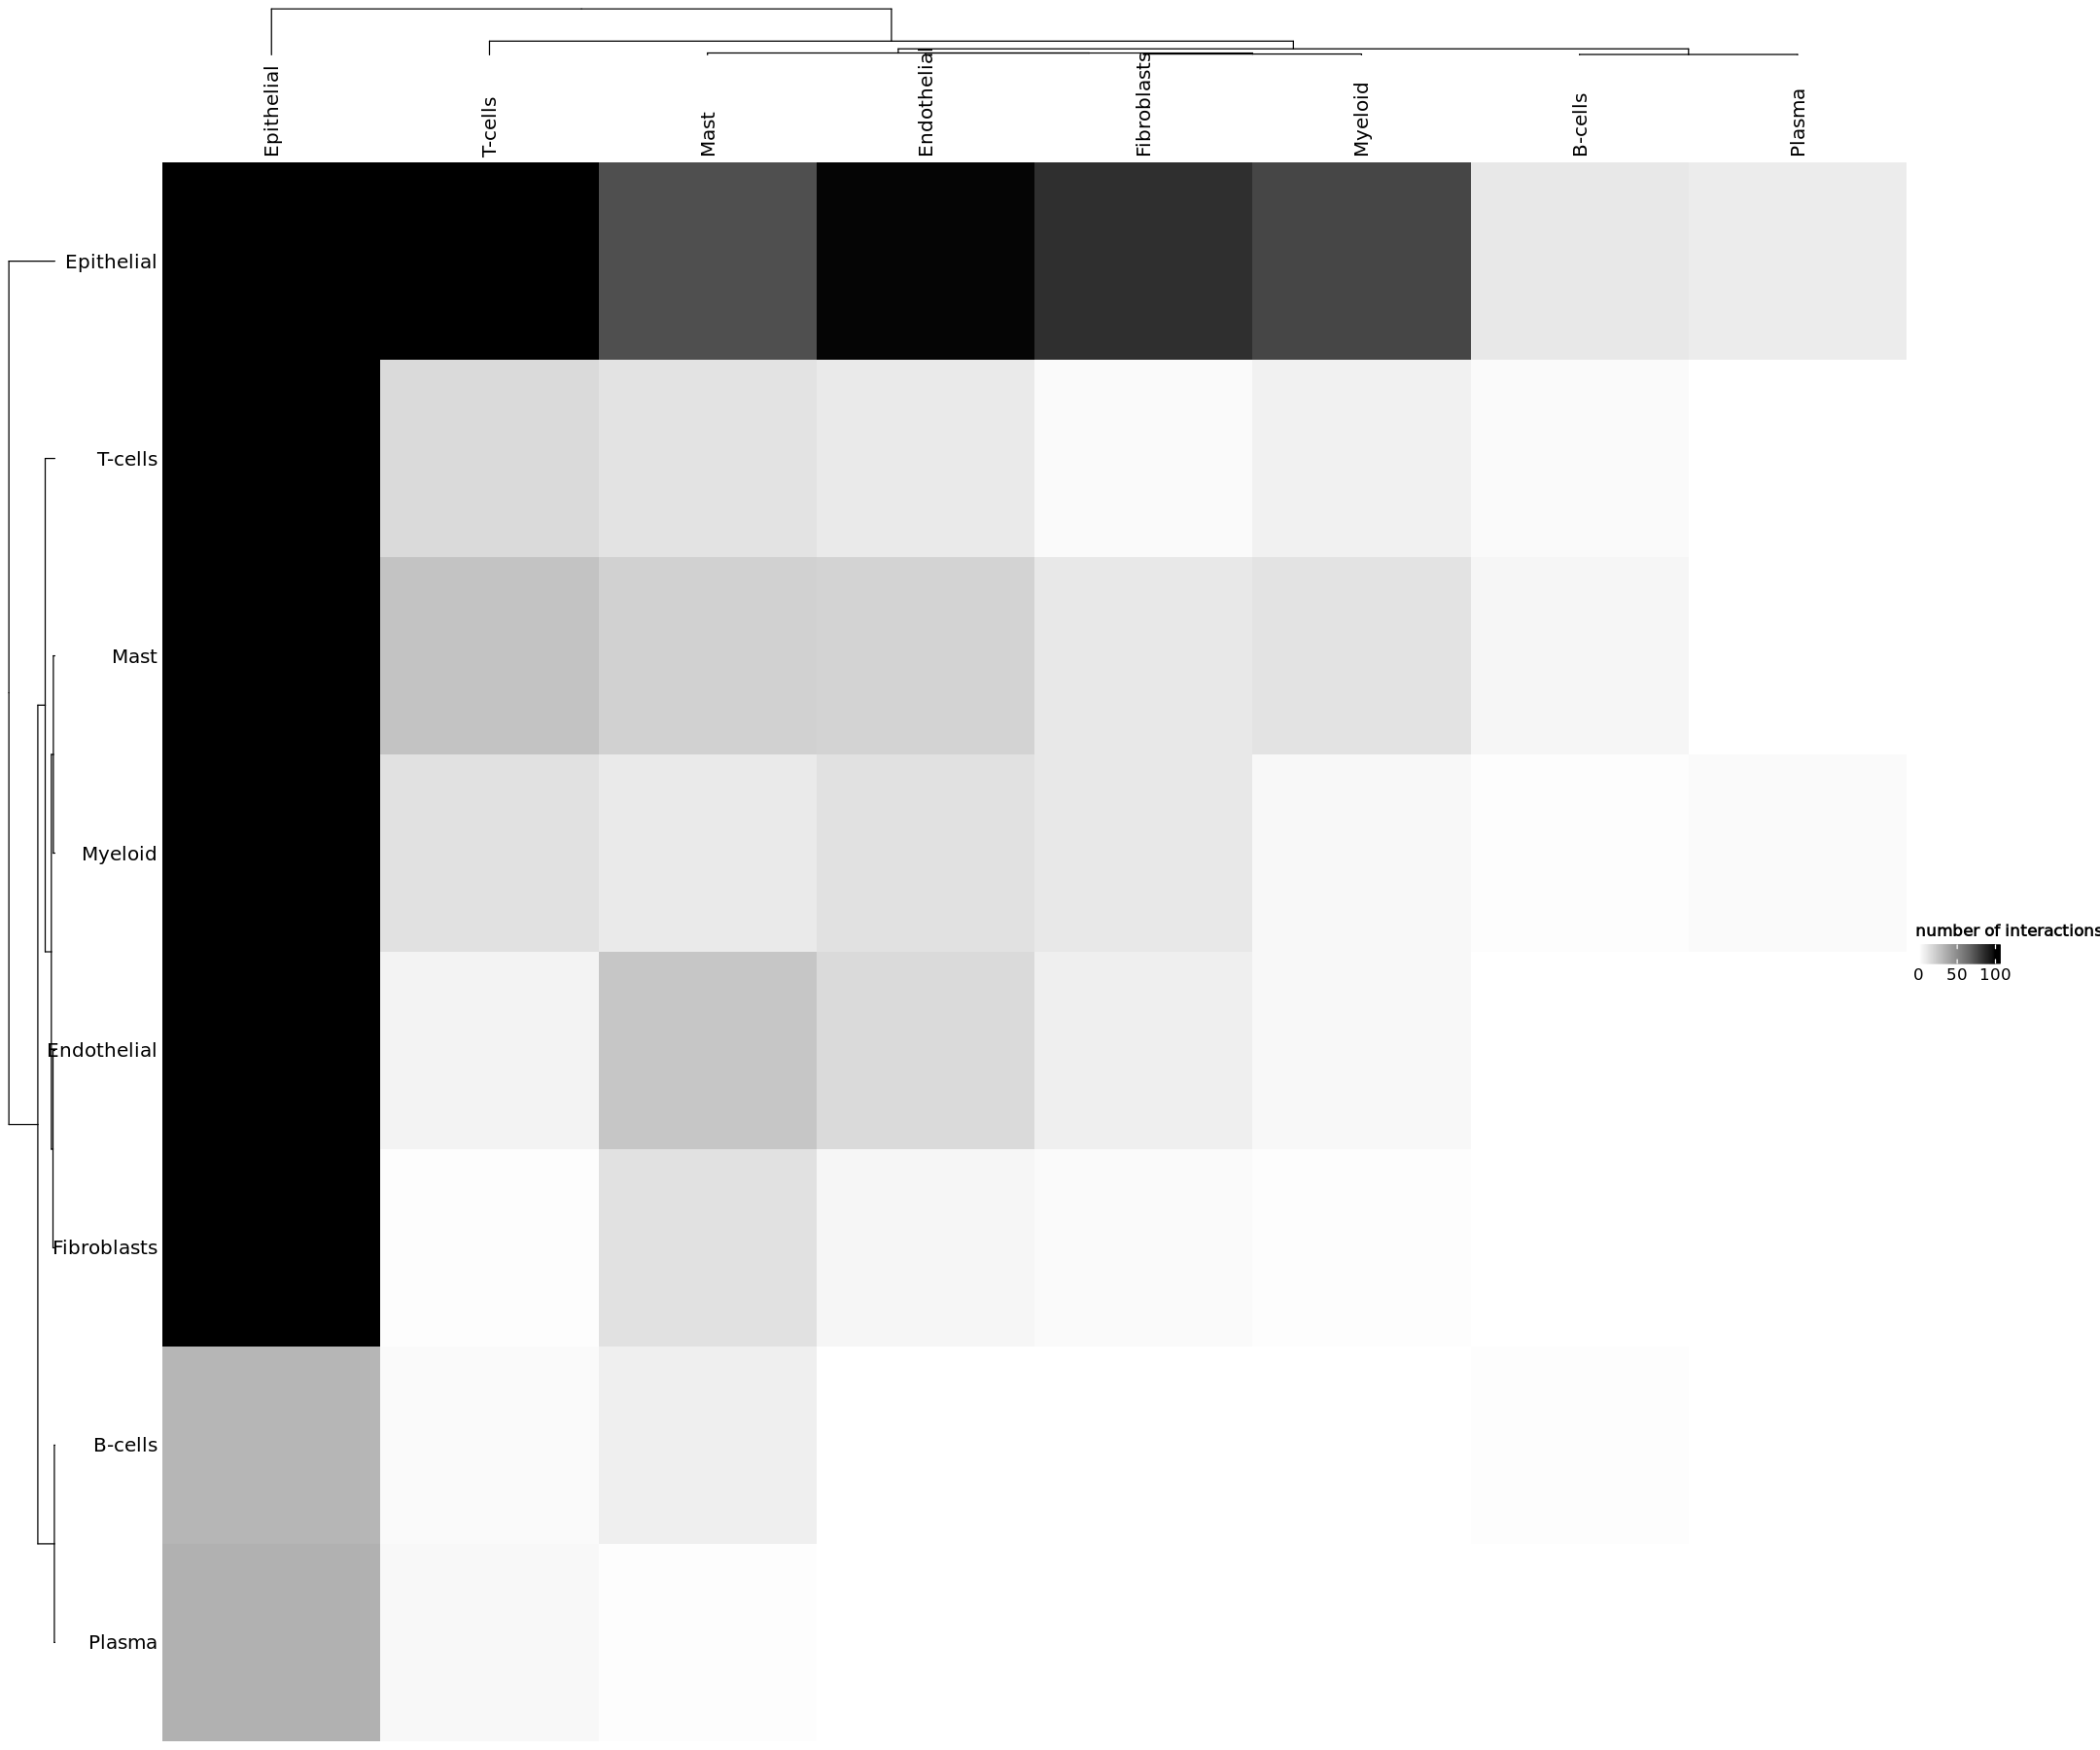

In [48]:
# mean number of interactions as heatmap
lapply(c("down"
         ,"up"
         #,"unchanged"
        )
       ,function(dir){
           # subset interactions
    ifelse(dir == "up"
              ,idx <- idx_good & idx_sign & idx_up
              ,ifelse(dir == "down"
                      ,idx <- idx_good & idx_sign & idx_down
                      ,idx <- !idx_sign & idx_good
                     )
              )
    
    # create a dummy data frame
    df <- as.data.frame(matrix(,nrow = length(cell_types)
                              ,ncol = length(cell_types)
                              )
                       )
    rownames(df) <- cell_types
    colnames(df) <- cell_types
    
    # populate the data frame
    for(send in cell_types){
        idx_send <- interactions$anno_interactions$sending_cell_type == send
        
        for(rec in cell_types){
            idx_rec <- interactions$anno_interactions$receiving_cell_type == rec
            
            print(send)
            print(rec)
            print(head(interactions$anno_interactions[idx & idx_send & idx_rec,c("interaction_ID","log2FC_weights", "sign")]))
            print(sum(idx & idx_send & idx_rec))
            
            df[send,rec] <- sum(idx & idx_send & idx_rec)
            
        }
    }
    
    print(df)
           
    my_color <-  colorRamp2(seq(0
                                ,100 #300
                                , length = 4)
                            , c("white","gray70","gray40","black"))
    
    h <- Heatmap(df
                 ,name = "number of interactions"
                 ,heatmap_legend_param = list(direction = "horizontal")
                 ,column_names_side = "top"
                 ,row_names_side = "left"
                 ,col = my_color
                )
           print(h
             #,heatmap_legend_side = "bottom"
                )
           
    pdf(file=paste0("figures/heatmap_cellTypes_number_"
                   ,dir
                   ,".pdf"))
          print(h
             #,heatmap_legend_side = "bottom"
               )
           dev.off()
    
       }
       )

### GO

[1] "Epithelial"
[1] "up"
 'table' int [1:480(1d)] 120 67 64 61 51 42 38 37 35 35 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:480] "EGFR" "ERBB2" "LDLR" "ITGB1" ...
NULL


'select()' returned 1:1 mapping between keys and columns



 'table' int [1:480(1d)] 120 67 64 61 51 42 38 37 35 35 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:480] "EGFR" "ERBB2" "LDLR" "ITGB1" ...
NULL
'data.frame':	100 obs. of  2 variables:
 $ SYMBOL  : chr  "EGFR" "ERBB2" "LDLR" "ITGB1" ...
 $ ENTREZID: chr  "1956" "2064" "3949" "3688" ...
NULL
[1] "Epithelial"
[1] "down"
 int(0) 
NULL
[1] "Fibroblasts"
[1] "up"
 'table' int [1:141(1d)] 20 13 8 7 6 6 6 5 5 5 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:141] "ITGB1" "CD44" "CALM1" "APP" ...
NULL


'select()' returned 1:1 mapping between keys and columns



 'table' int [1:141(1d)] 20 13 8 7 6 6 6 5 5 5 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:141] "ITGB1" "CD44" "CALM1" "APP" ...
NULL
'data.frame':	100 obs. of  2 variables:
 $ SYMBOL  : chr  "ITGB1" "CD44" "CALM1" "APP" ...
 $ ENTREZID: chr  "3688" "960" "801" "351" ...
NULL
[1] "Fibroblasts"
[1] "down"
 'table' int [1:79(1d)] 40 30 14 9 9 9 8 6 4 4 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:79] "CD4" "LAG3" "EPOR" "CD69" ...
NULL


'select()' returned 1:1 mapping between keys and columns



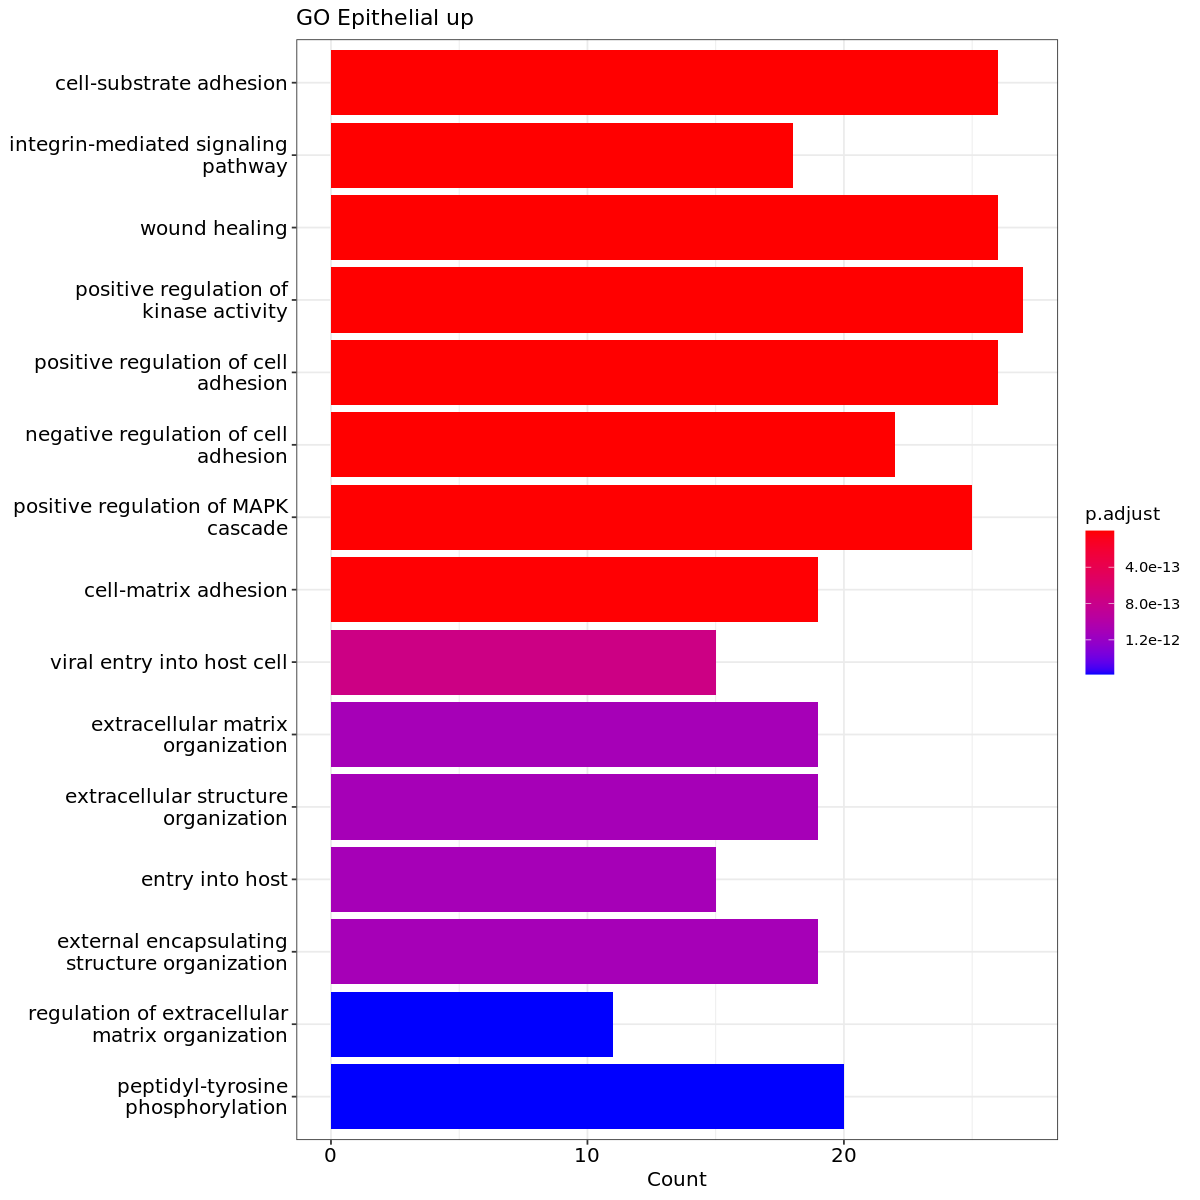

 'table' int [1:79(1d)] 40 30 14 9 9 9 8 6 4 4 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:79] "CD4" "LAG3" "EPOR" "CD69" ...
NULL
'data.frame':	79 obs. of  2 variables:
 $ SYMBOL  : chr  "CD4" "LAG3" "EPOR" "CD69" ...
 $ ENTREZID: chr  "920" "3902" "2057" "969" ...
NULL
[1] "Endothelial"
[1] "up"
 'table' int [1:123(1d)] 23 22 12 11 9 9 8 8 8 8 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:123] "AQP1" "ITGB1" "LAMA5" "INSR" ...
NULL


'select()' returned 1:1 mapping between keys and columns



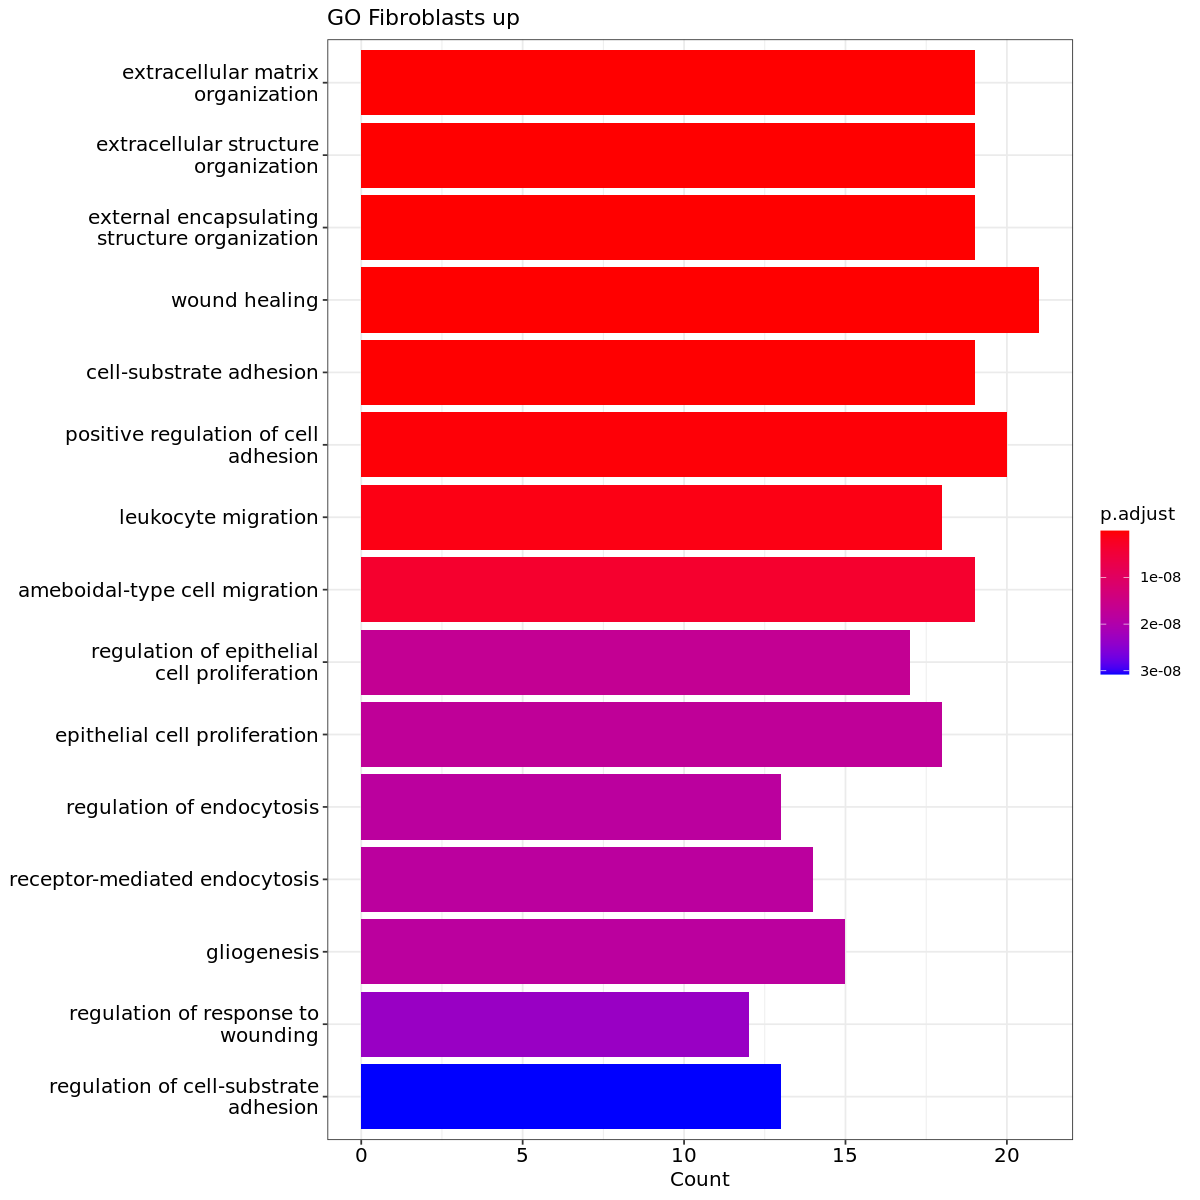

 'table' int [1:123(1d)] 23 22 12 11 9 9 8 8 8 8 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:123] "AQP1" "ITGB1" "LAMA5" "INSR" ...
NULL
'data.frame':	99 obs. of  2 variables:
 $ SYMBOL  : chr  "AQP1" "ITGB1" "LAMA5" "INSR" ...
 $ ENTREZID: chr  "358" "3688" "3911" "3643" ...
NULL
[1] "Endothelial"
[1] "down"
 'table' int [1:15(1d)] 3 2 2 2 2 2 2 1 1 1 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:15] "HLA-DRB1" "HLA-DPA1" "HLA-DPB1" "HLA-DQB1" ...
NULL


'select()' returned 1:1 mapping between keys and columns



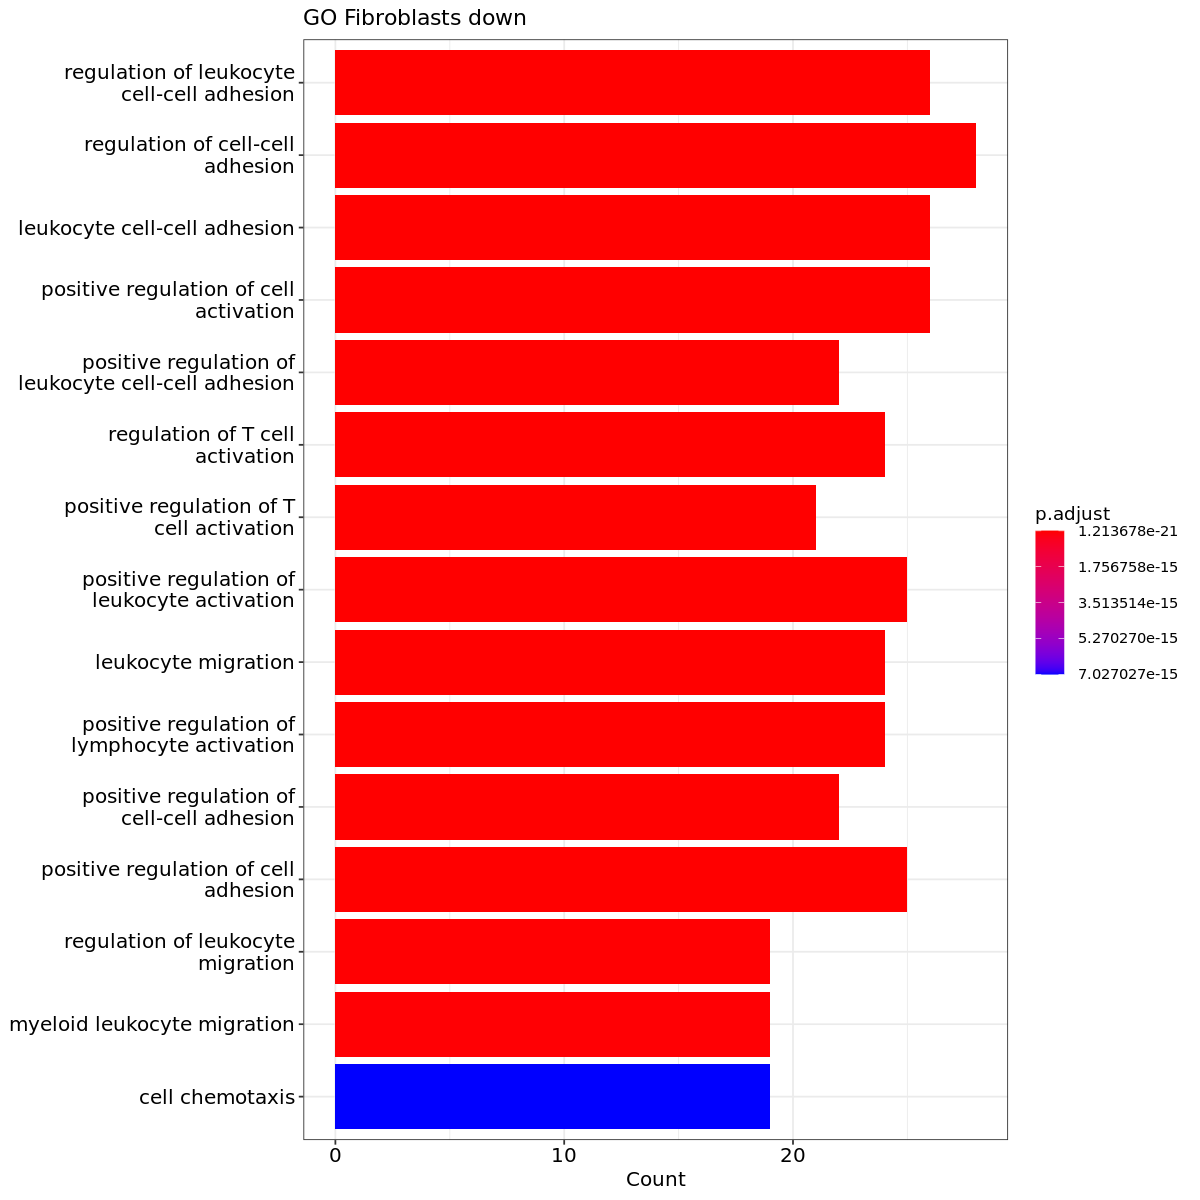

 'table' int [1:15(1d)] 3 2 2 2 2 2 2 1 1 1 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:15] "HLA-DRB1" "HLA-DPA1" "HLA-DPB1" "HLA-DQB1" ...
NULL
'data.frame':	15 obs. of  2 variables:
 $ SYMBOL  : chr  "HLA-DRB1" "HLA-DPA1" "HLA-DPB1" "HLA-DQB1" ...
 $ ENTREZID: chr  "3123" "3113" "3115" "3119" ...
NULL
[1] "Myeloid"
[1] "up"
 'table' int [1:113(1d)] 32 30 10 8 7 7 6 6 5 5 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:113] "APP" "CD44" "CALM1" "ITGB1" ...
NULL


'select()' returned 1:1 mapping between keys and columns



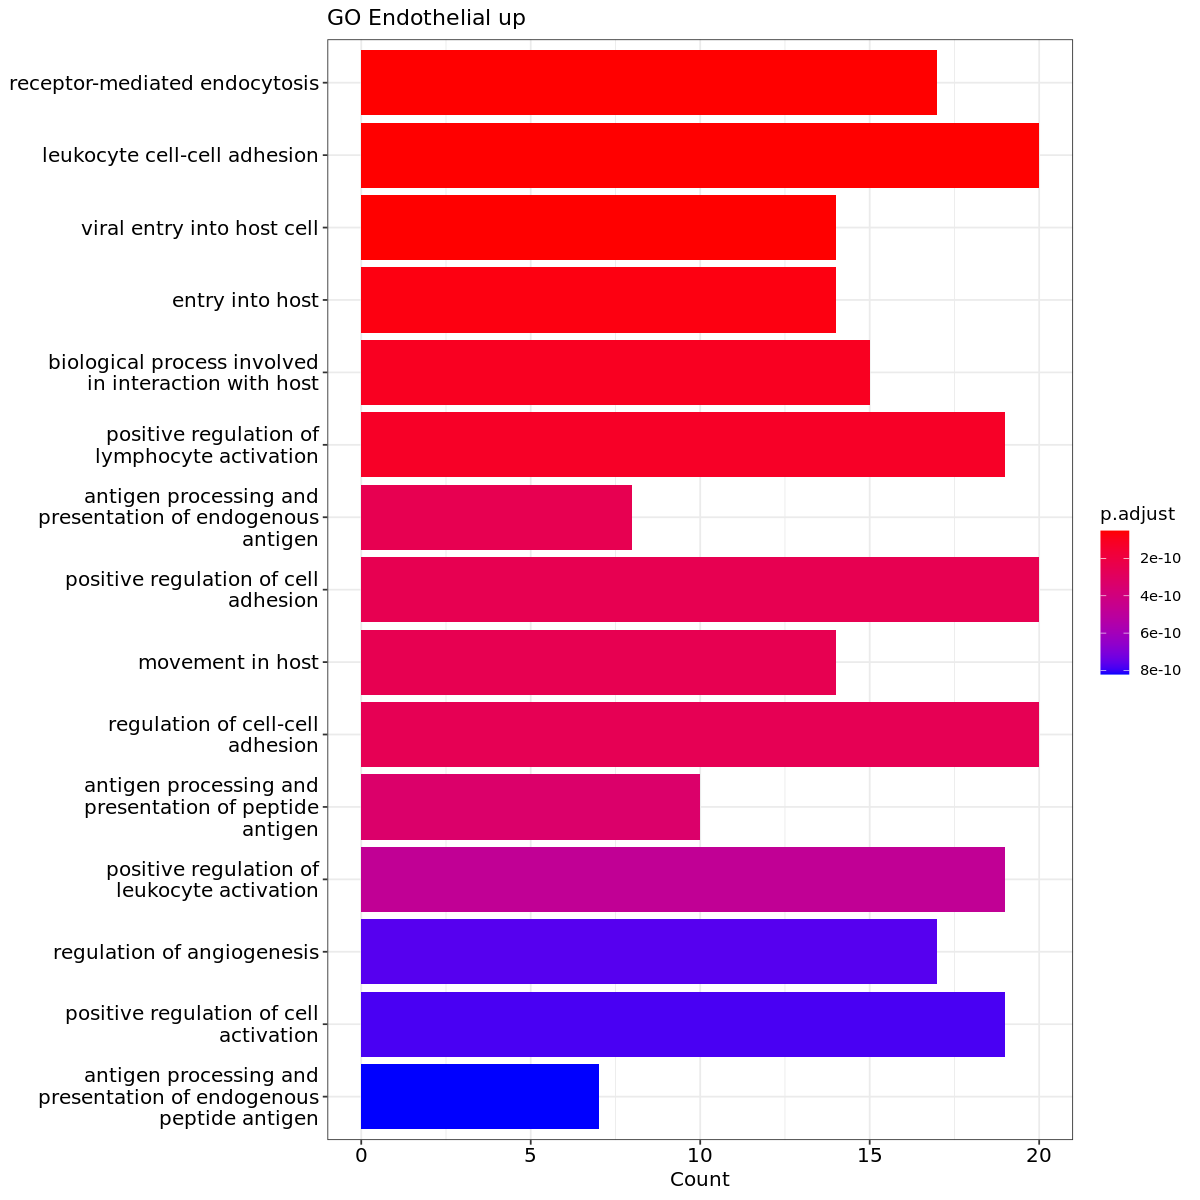

 'table' int [1:113(1d)] 32 30 10 8 7 7 6 6 5 5 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:113] "APP" "CD44" "CALM1" "ITGB1" ...
NULL
'data.frame':	99 obs. of  2 variables:
 $ SYMBOL  : chr  "APP" "CD44" "CALM1" "ITGB1" ...
 $ ENTREZID: chr  "351" "960" "801" "3688" ...
NULL
[1] "Myeloid"
[1] "down"
 'table' int [1:56(1d)] 13 11 8 8 6 4 4 4 3 3 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:56] "CD4" "CXCR4" "HLA-DRA" "MIF" ...
NULL


'select()' returned 1:1 mapping between keys and columns



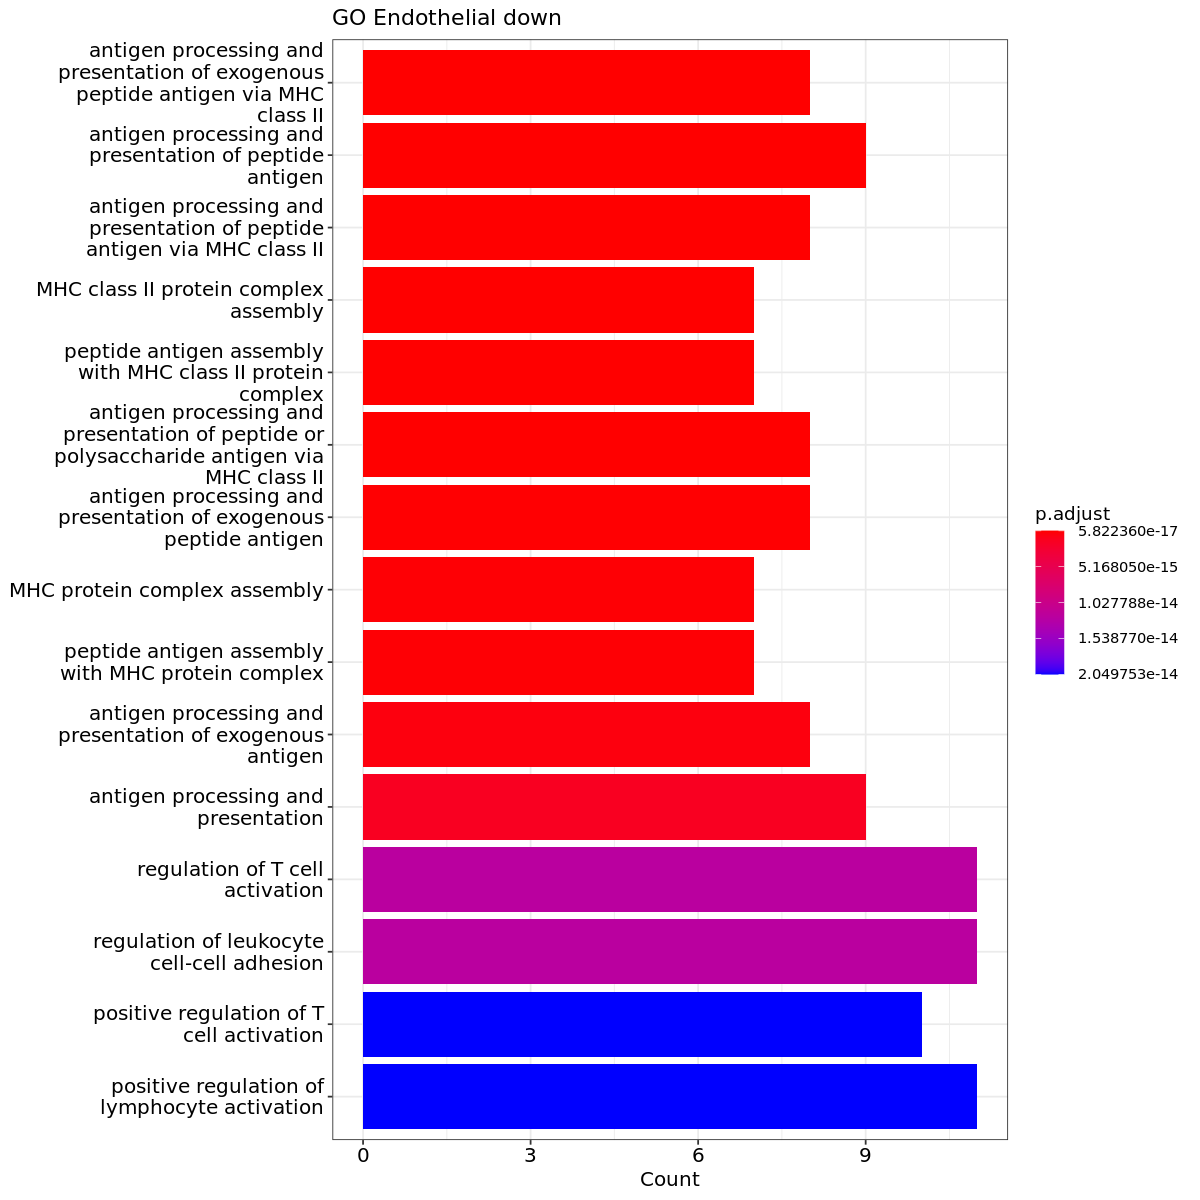

 'table' int [1:56(1d)] 13 11 8 8 6 4 4 4 3 3 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:56] "CD4" "CXCR4" "HLA-DRA" "MIF" ...
NULL
'data.frame':	56 obs. of  2 variables:
 $ SYMBOL  : chr  "CD4" "CXCR4" "HLA-DRA" "MIF" ...
 $ ENTREZID: chr  "920" "7852" "3122" "4282" ...
NULL
[1] "Mast"
[1] "up"
 'table' int [1:79(1d)] 41 38 21 20 19 19 14 11 9 9 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:79] "CD44" "ADRB2" "CALM1" "KIT" ...
NULL


'select()' returned 1:1 mapping between keys and columns



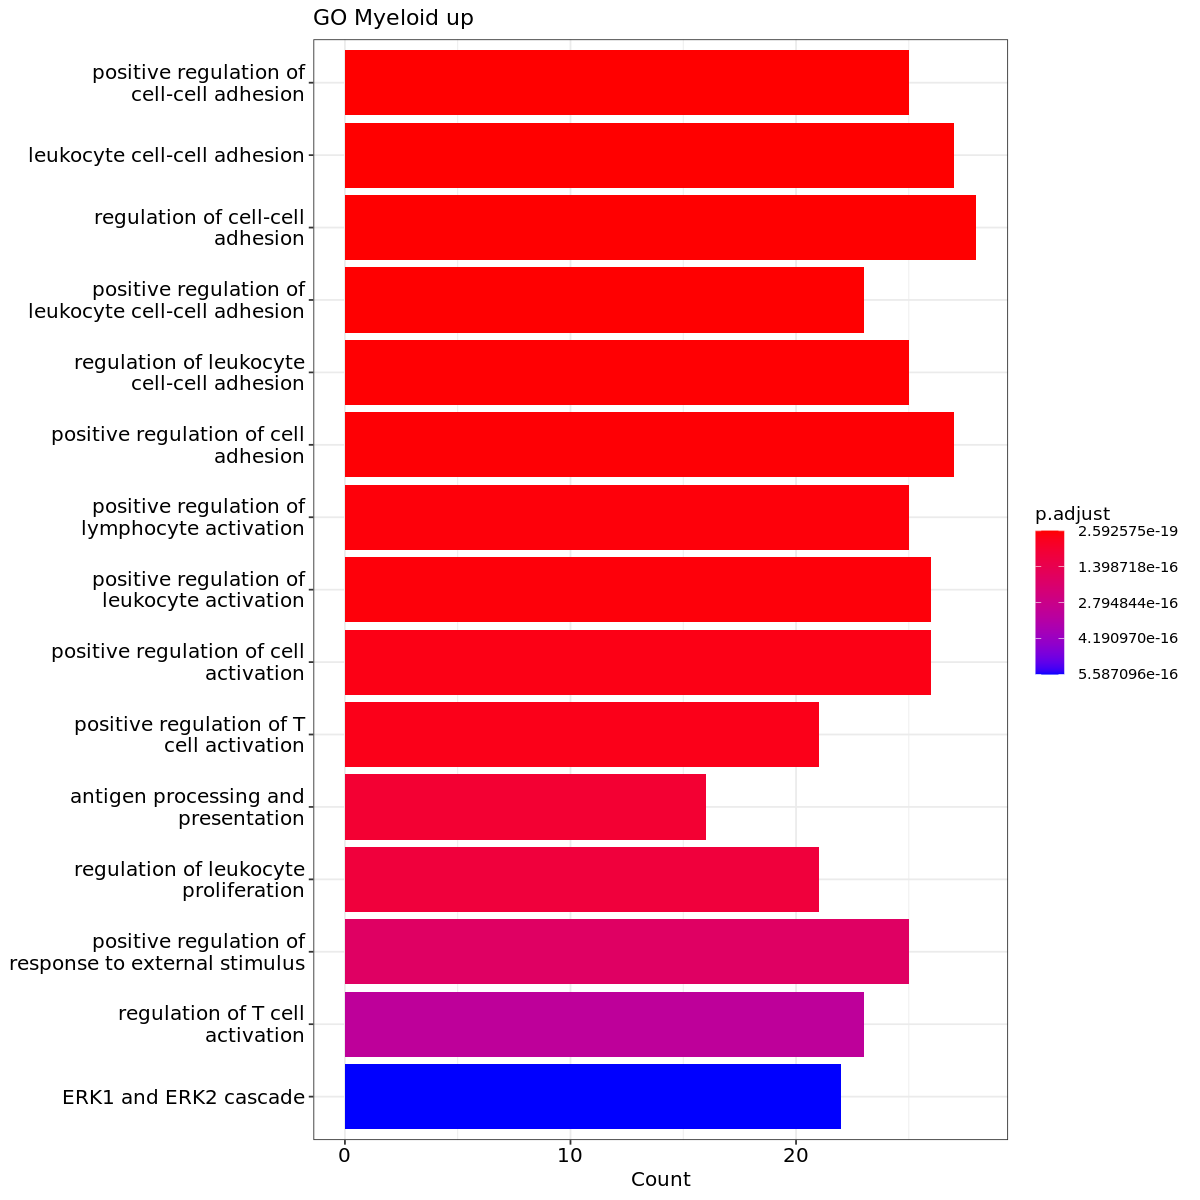

 'table' int [1:79(1d)] 41 38 21 20 19 19 14 11 9 9 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:79] "CD44" "ADRB2" "CALM1" "KIT" ...
NULL
'data.frame':	78 obs. of  2 variables:
 $ SYMBOL  : chr  "CD44" "ADRB2" "CALM1" "KIT" ...
 $ ENTREZID: chr  "960" "154" "801" "3815" ...
NULL
[1] "Mast"
[1] "down"
 int(0) 
NULL
[1] "T-cells"
[1] "up"
 'table' int [1:205(1d)] 34 28 14 14 14 13 11 11 11 11 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:205] "CD44" "LDLR" "ADAM10" "APP" ...
NULL


'select()' returned 1:1 mapping between keys and columns



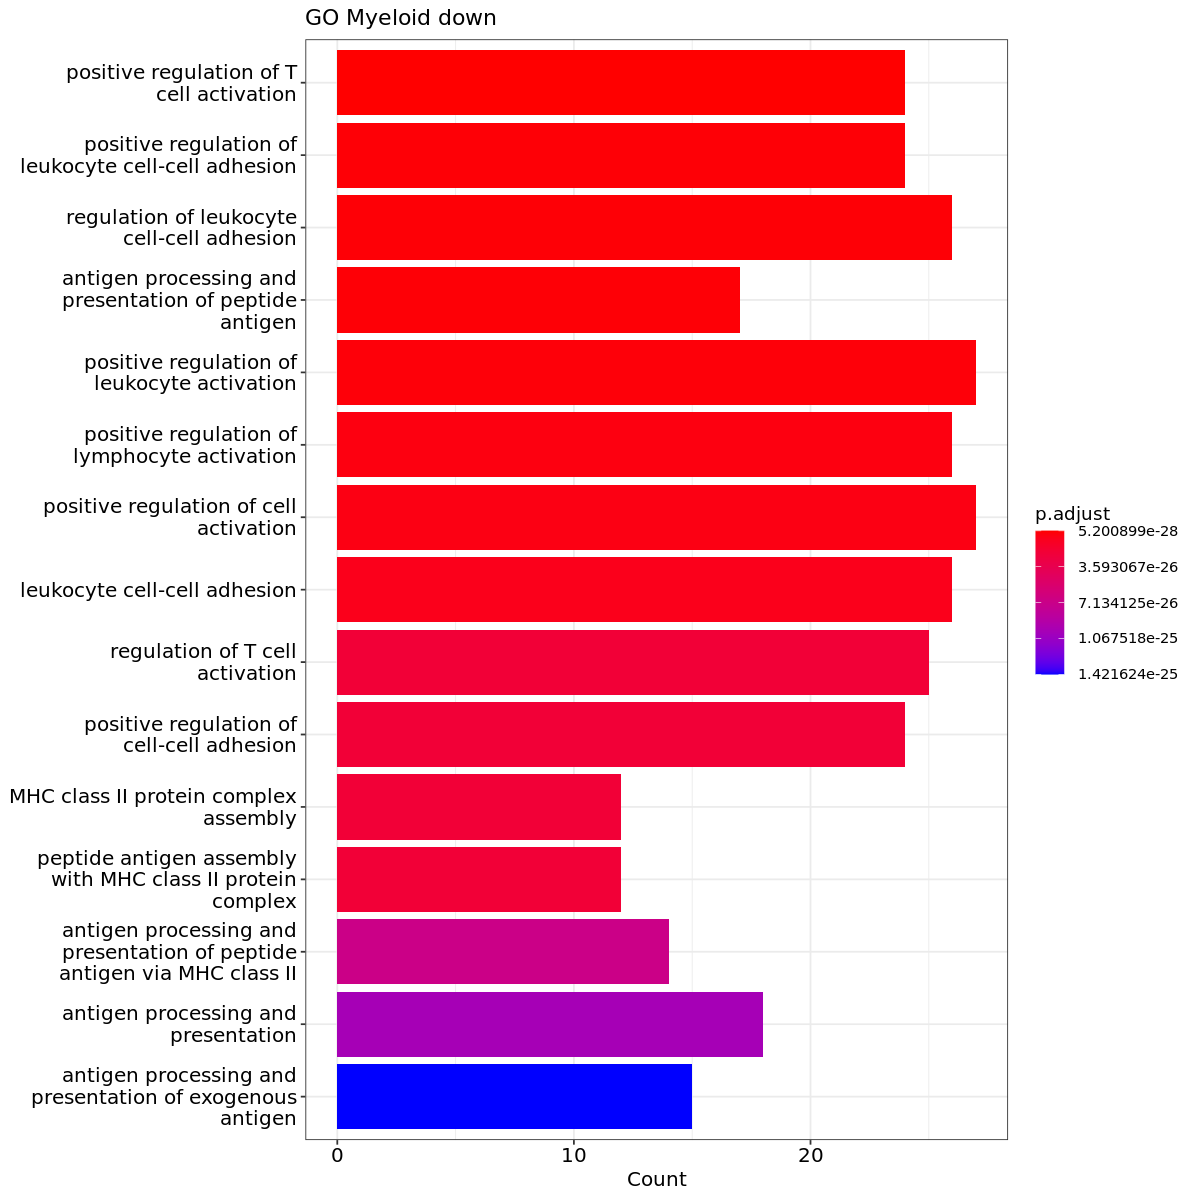

 'table' int [1:205(1d)] 34 28 14 14 14 13 11 11 11 11 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:205] "CD44" "LDLR" "ADAM10" "APP" ...
NULL
'data.frame':	100 obs. of  2 variables:
 $ SYMBOL  : chr  "CD44" "LDLR" "ADAM10" "APP" ...
 $ ENTREZID: chr  "960" "3949" "102" "351" ...
NULL
[1] "T-cells"
[1] "down"
 'table' int [1:38(1d)] 6 5 4 4 4 4 3 3 2 2 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:38] "CXCR4" "CCR5" "APOE" "CD3D" ...
NULL


'select()' returned 1:1 mapping between keys and columns



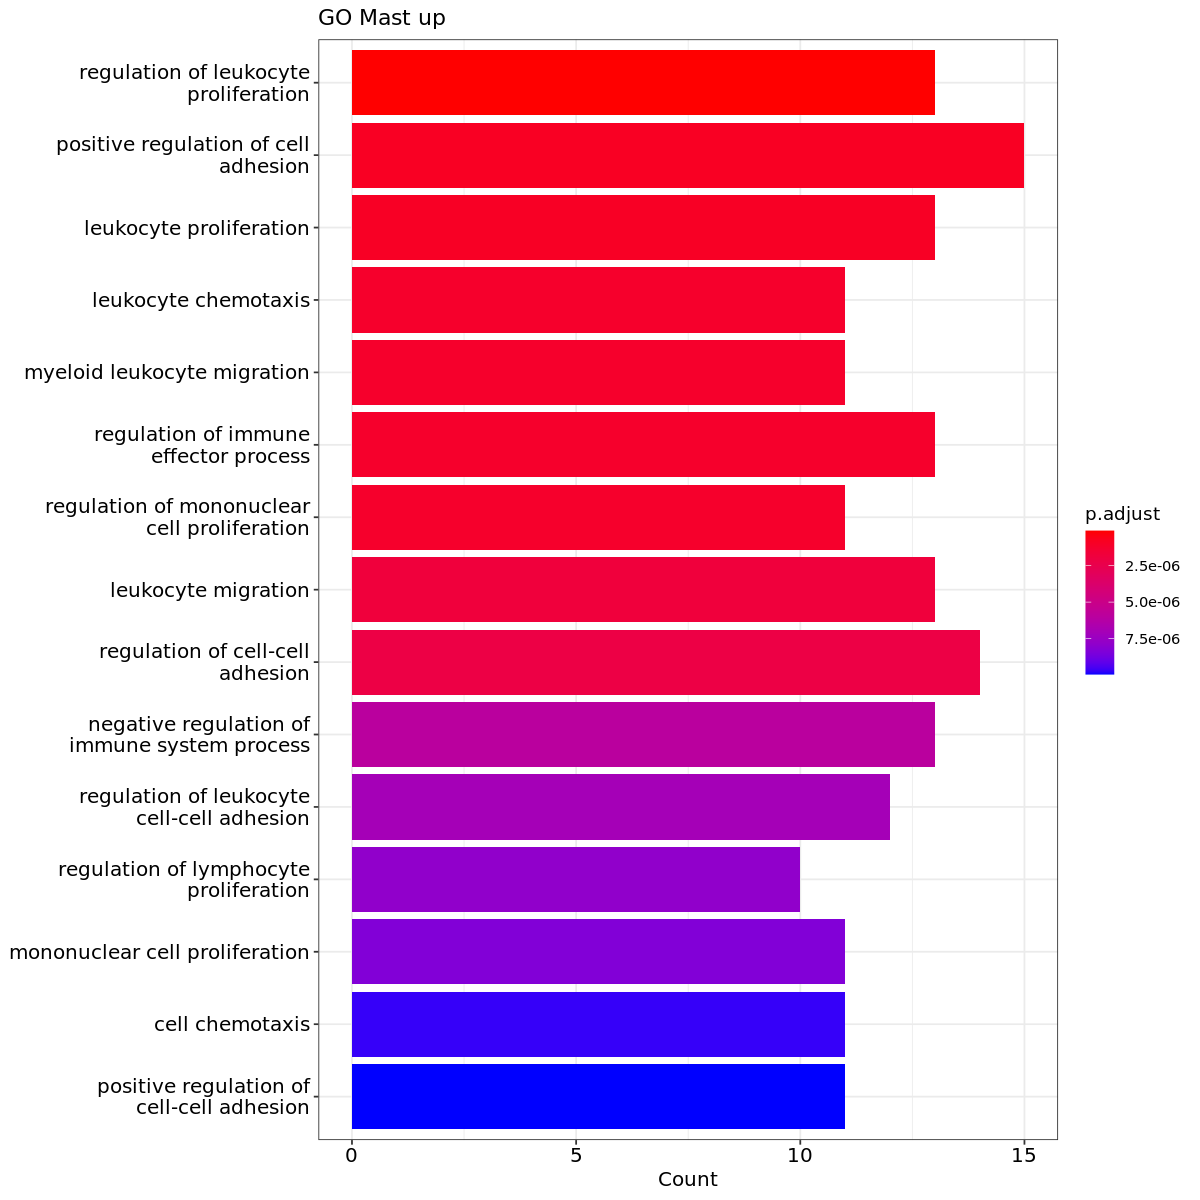

 'table' int [1:38(1d)] 6 5 4 4 4 4 3 3 2 2 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:38] "CXCR4" "CCR5" "APOE" "CD3D" ...
NULL
'data.frame':	38 obs. of  2 variables:
 $ SYMBOL  : chr  "CXCR4" "CCR5" "APOE" "CD3D" ...
 $ ENTREZID: chr  "7852" "1234" "348" "915" ...
NULL
[1] "Plasma"
[1] "up"
 'table' int [1:22(1d)] 6 5 5 5 3 3 2 2 2 2 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:22] "UBA52" "CALM1" "CD44" "RPS27A" ...
NULL


'select()' returned 1:1 mapping between keys and columns



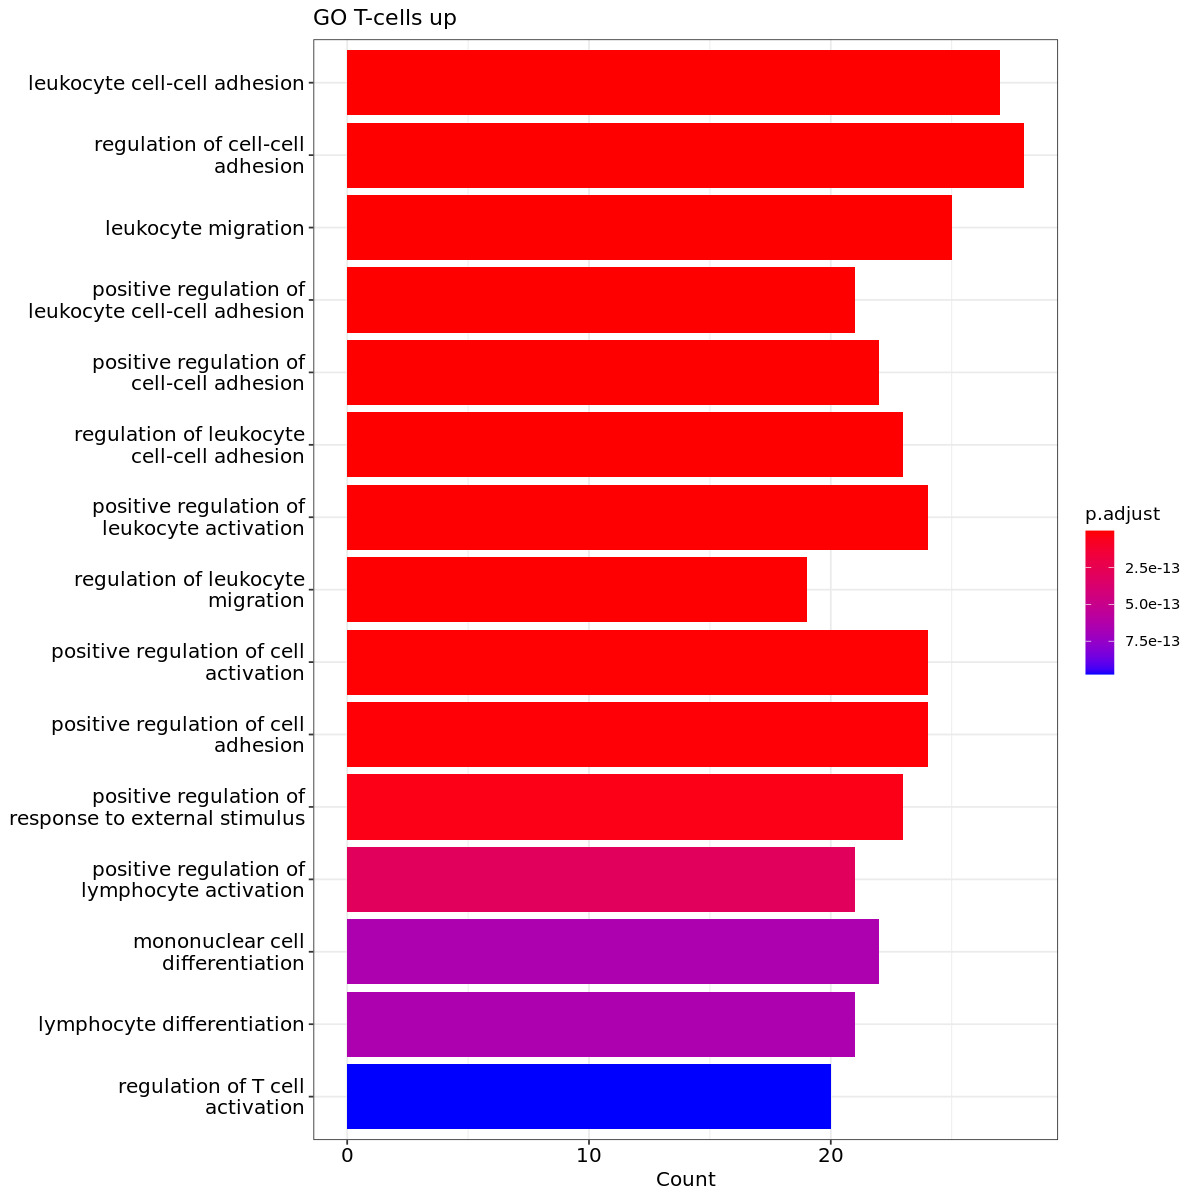

 'table' int [1:22(1d)] 6 5 5 5 3 3 2 2 2 2 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:22] "UBA52" "CALM1" "CD44" "RPS27A" ...
NULL
'data.frame':	22 obs. of  2 variables:
 $ SYMBOL  : chr  "UBA52" "CALM1" "CD44" "RPS27A" ...
 $ ENTREZID: chr  "7311" "801" "960" "6233" ...
NULL
[1] "Plasma"
[1] "down"
 'table' int [1:53(1d)] 11 10 6 5 5 4 4 4 4 4 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:53] "MIF" "CD44" "CD74" "CCR10" ...
NULL


'select()' returned 1:1 mapping between keys and columns



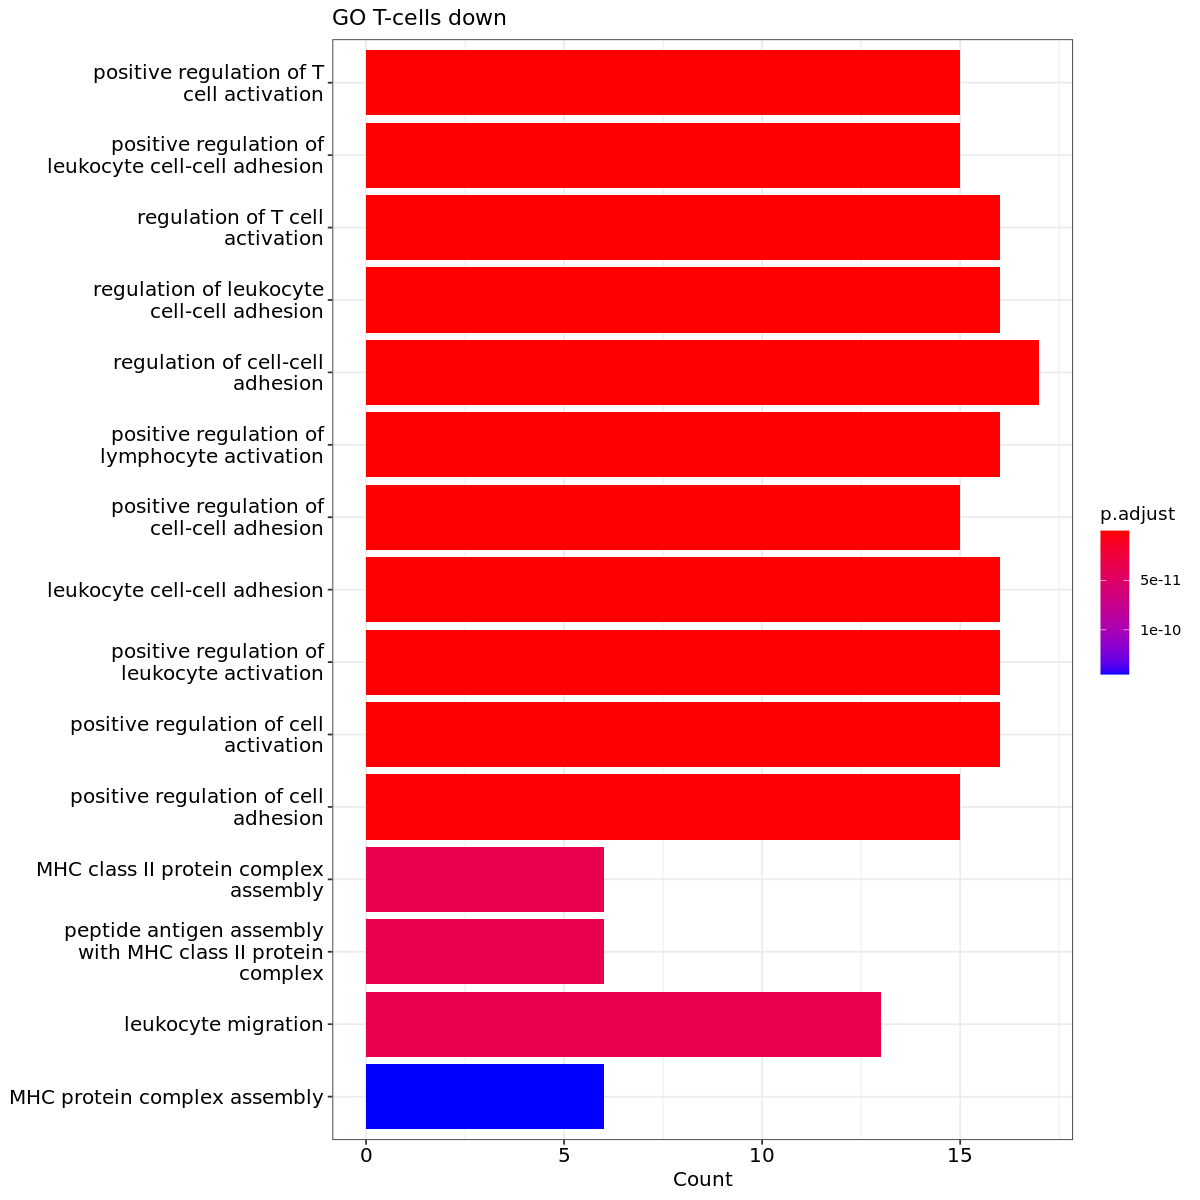

 'table' int [1:53(1d)] 11 10 6 5 5 4 4 4 4 4 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:53] "MIF" "CD44" "CD74" "CCR10" ...
NULL
'data.frame':	53 obs. of  2 variables:
 $ SYMBOL  : chr  "MIF" "CD44" "CD74" "CCR10" ...
 $ ENTREZID: chr  "4282" "960" "972" "2826" ...
NULL
[1] "B-cells"
[1] "up"
 'table' int [1:32(1d)] 7 5 5 4 3 3 2 2 2 2 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:32] "UBA52" "CALM1" "RPS27A" "HLA-DRA" ...
NULL


'select()' returned 1:1 mapping between keys and columns



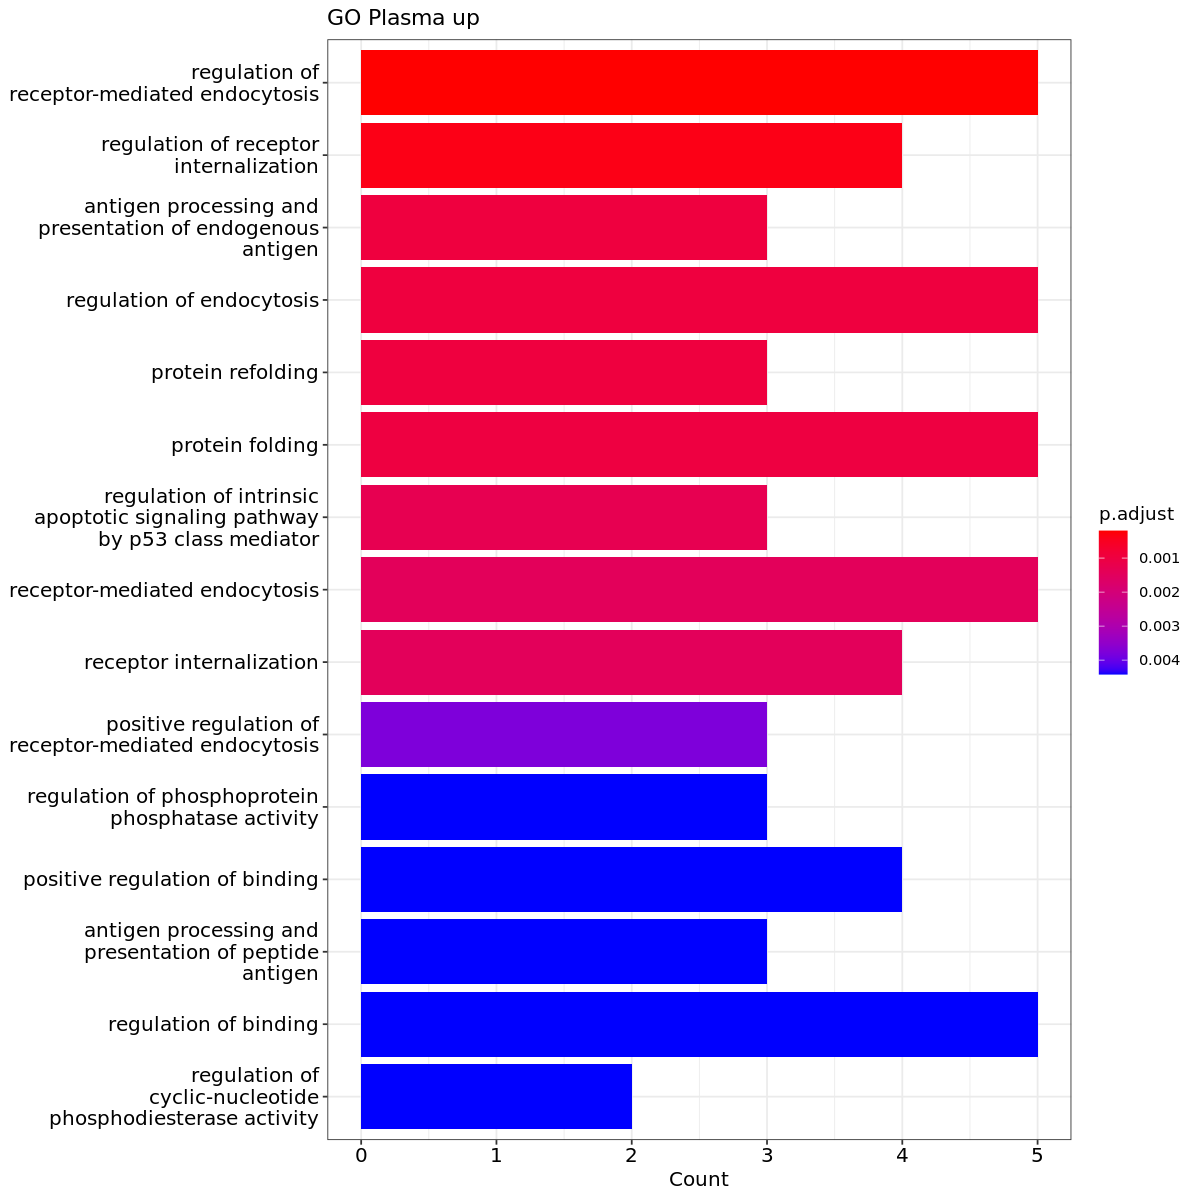

 'table' int [1:32(1d)] 7 5 5 4 3 3 2 2 2 2 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:32] "UBA52" "CALM1" "RPS27A" "HLA-DRA" ...
NULL
'data.frame':	31 obs. of  2 variables:
 $ SYMBOL  : chr  "UBA52" "CALM1" "RPS27A" "HLA-DRA" ...
 $ ENTREZID: chr  "7311" "801" "6233" "3122" ...
NULL


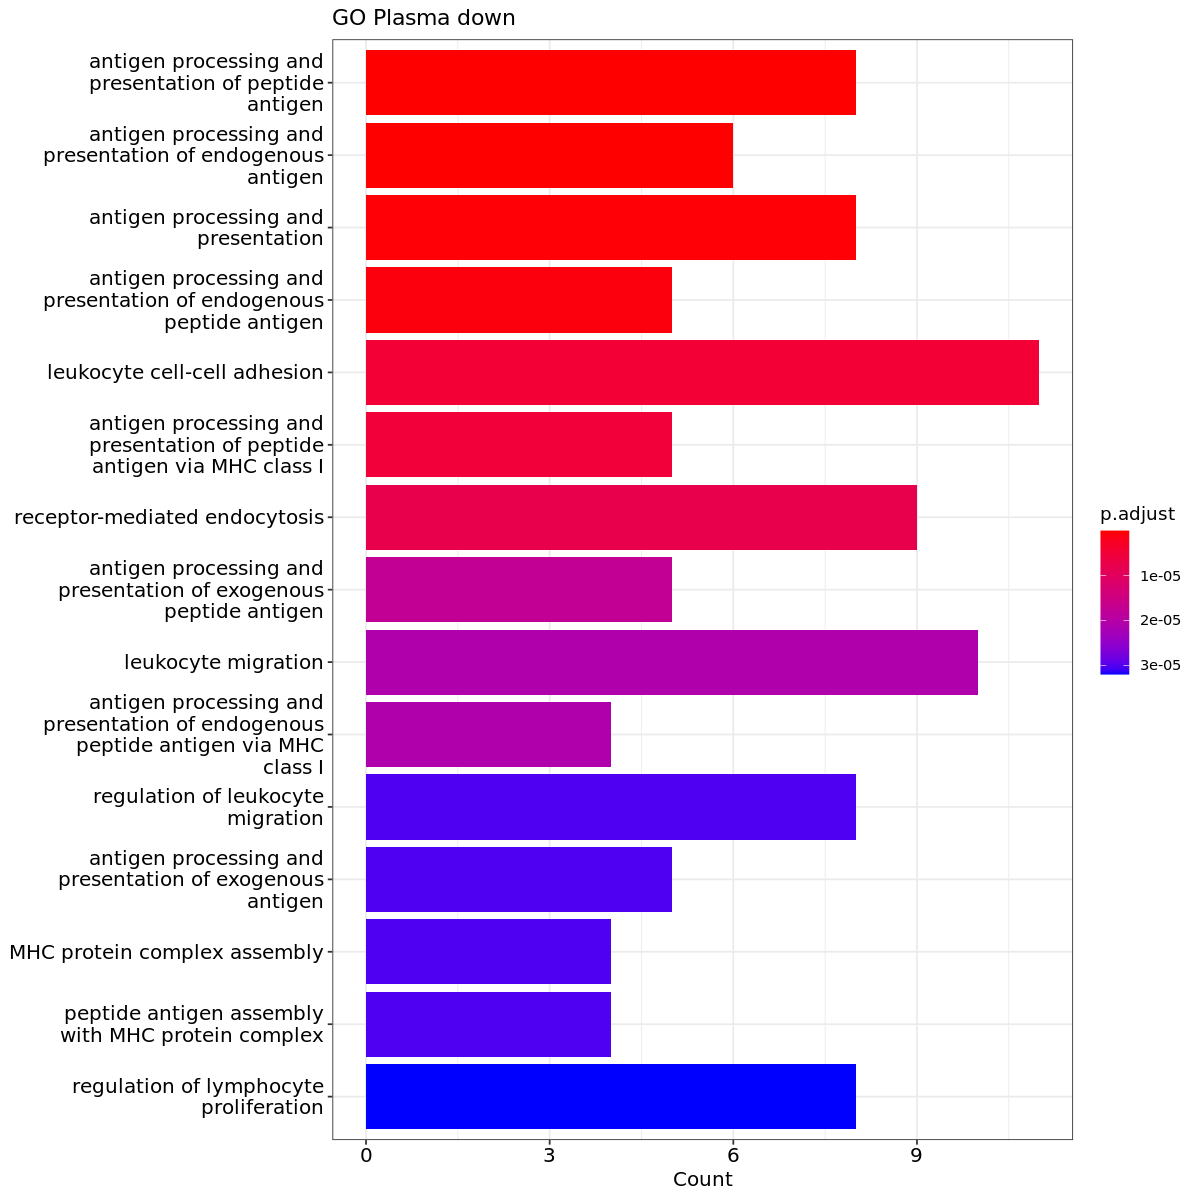

[1] "B-cells"
[1] "down"
 int(0) 
NULL


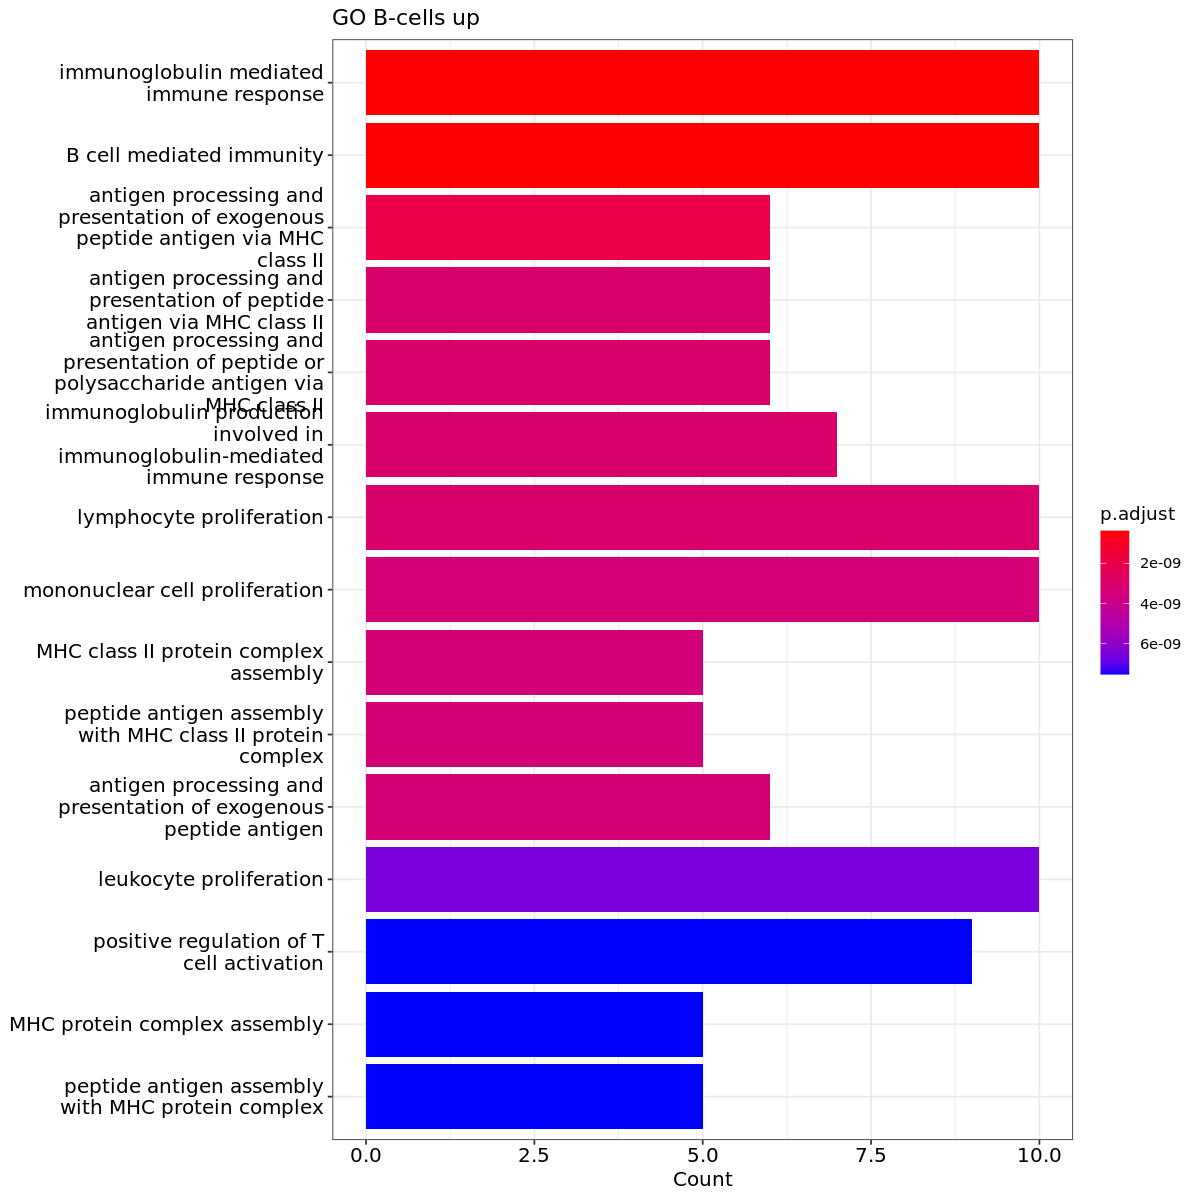

In [49]:
# enrichment of all ligs/rec in down / up-regulated interactions by cell type
options(repr.plot.width = 10
       ,repr.plot.height = 10)
cell_type <- unique(interactions$anno_cells$cell_type)
enrichment <- lapply(cell_type
                     ,function(my_cell_type){
                         
                         idx_sending <- interactions$anno_interactions$sending_cell_type == my_cell_type
                         idx_receiving <- interactions$anno_interactions$receiving_cell_type == my_cell_type
             my_analysis <- lapply(c("up"
                                  ,"down"
                                 )
                                ,function(direction){
                                     print(my_cell_type)
                                    print(direction)
                                    
          ifelse(direction == "up"
                ,idx <- idx_sign & idx_up
                ,idx <- idx_sign & idx_down)
          my_genes <- sort(table(c(interactions$anno_interactions$ligand_gene_name[idx & idx_sending]
                           ,interactions$anno_interactions$receptor_gene_name[idx & idx_receiving]))
                          ,decreasing = TRUE)
          print(str(my_genes))
          if(length(my_genes) != 0){
              ifelse(length(my_genes)< 100
                ,top <- c(1:length(my_genes))
                ,top <- c(1:100))
        genes  <-  AnnotationDbi::select(org.Hs.eg.db, keys=names(my_genes)[top], columns="ENTREZID", keytype="SYMBOL")
        genes  <-  genes[!is.na(genes$ENTREZID),]
        print(str(my_genes))
        print(str(genes))

        #my_background <- unique(c(interactions$anno_interactions$ligand_gene_name[idx_good]
        #                   ,interactions$anno_interactions$receptor_gene_name[idx_good]))
        #background = AnnotationDbi::select(org.Hs.eg.db, keys=my_background, columns="ENTREZID", keytype="SYMBOL")
        #background = background[!is.na(background$ENTREZID),]
        #print(str(my_background))
        #print(str(background))

          a <- lapply(c("GO"
                   #,"KEGG"
                                 )
                 ,function(type_analysis){
                     if(type_analysis == "GO"){
                         BP <- enrichGO(gene = genes$ENTREZID
                                            #,universe = background$ENTREZID
                                            , OrgDb = org.Hs.eg.db
                                            , ont = "BP"
                                            , pAdjustMethod = "BH"
                                            , pvalueCutoff  = 0.01
                                            , qvalueCutoff  = 0.05
                                            , readable = TRUE
                                           )
                         if(sum(unique(BP@result$p.adjust) < 0.01)>0){
                             print(barplot(BP, showCategory=15) + ggtitle(paste(type_analysis,my_cell_type,direction)))
                         }
                        return(BP)
                     } else {
                         kk <- enrichKEGG(gene = genes$ENTREZID
                                            #,universe = background$ENTREZID
                                              ,organism     = 'hsa'
                                              ,pvalueCutoff = 0.05
                                                 )
                        print(barplot(kk, showCategory=15) + ggtitle(paste(type_analysis,my_cell_type,direction)))
                         return(kk)
                     }


          })
              return(a)
              }
                           
      })
                         names(my_analysis) <- c("up", "down")
                         my_analysis
                     })
names(enrichment) <- cell_type
#print(str(enrichment))

In [50]:
print(str(enrichment))

List of 8
 $ Epithelial :List of 2
  ..$ up  :List of 1
  .. ..$ :Formal class 'enrichResult' [package "DOSE"] with 15 slots
  .. .. .. ..@ result       :'data.frame':	3332 obs. of  9 variables:
  .. .. .. .. ..$ ID         : chr [1:3332] "GO:0031589" "GO:0007229" "GO:0042060" "GO:0033674" ...
  .. .. .. .. ..$ Description: chr [1:3332] "cell-substrate adhesion" "integrin-mediated signaling pathway" "wound healing" "positive regulation of kinase activity" ...
  .. .. .. .. ..$ GeneRatio  : chr [1:3332] "26/99" "18/99" "26/99" "27/99" ...
  .. .. .. .. ..$ BgRatio    : chr [1:3332] "369/18903" "113/18903" "442/18903" "496/18903" ...
  .. .. .. .. ..$ pvalue     : num [1:3332] 2.10e-22 3.91e-22 2.03e-20 2.48e-20 1.95e-19 ...
  .. .. .. .. ..$ p.adjust   : num [1:3332] 6.52e-19 6.52e-19 2.06e-17 2.06e-17 1.30e-16 ...
  .. .. .. .. ..$ qvalue     : num [1:3332] 3.45e-19 3.45e-19 1.09e-17 1.09e-17 6.89e-17 ...
  .. .. .. .. ..$ geneID     : chr [1:3332] "ITGB1/CD44/ITGA6/ITGA2/SMAD3/MDK/LAM

# Export

In [51]:
print("save interactions_healthy_sub.RData")
save(interactions, file = "interactions_inflamed_healthy_sub.RData")

[1] "save interactions_healthy_sub.RData"
